<a href="https://colab.research.google.com/github/AmandaGamage/spectrum_sharing_with_stable_diffusion/blob/main/Stable_diffusion_image_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00


In [2]:
import argparse, logging, copy
from types import SimpleNamespace
from contextlib import nullcontext
import pickle
import torch
from torch import optim
import torch.nn as nn
import numpy as np
import os, random
from pathlib import Path
#from kaggle import api
import torch
import torchvision
import torchvision.transforms as T
import numpy as np
from PIL import Image
from fastdownload import FastDownload
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from fastprogress import progress_bar
import torch.nn.functional as F
from PIL import Image
import wandb
from pathlib import Path

In [3]:
class utils:
    cifar_labels = "airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck".split(",")
    alphabet_labels = "A B C D E F G H I J K L M N O P Q R S T U V W X Y Z".split(" ")


    def set_seed(s, reproducible=False):
        "Set random seed for `random`, `torch`, and `numpy` (where available)"
        try: torch.manual_seed(s)
        except NameError: pass
        try: torch.cuda.manual_seed_all(s)
        except NameError: pass
        try: np.random.seed(s%(2**32-1))
        except NameError: pass
        random.seed(s)
        if reproducible:
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

    def untar_data(url, force_download=False, base='./datasets'):
        d = FastDownload(base=base)
        return d.get(url, force=force_download, extract_key='data')

    '''def get_kaggle_dataset(dataset_path, # Local path to download dataset to
                    dataset_slug, # Dataset slug (ie "zillow/zecon")
                    unzip=True, # Should it unzip after downloading?
                    force=False # Should it overwrite or error if dataset_path exists?
                ):
        Downloads an existing dataset and metadata from kaggle
        if not force and Path(dataset_path).exists():
            return Path(dataset_path)
        api.dataset_metadata(dataset_slug, str(dataset_path))
        api.dataset_download_files(dataset_slug, str(dataset_path))
        if unzip:
            zipped_file = Path(dataset_path)/f"{dataset_slug.split('/')[-1]}.zip"
            import zipfile
            with zipfile.ZipFile(zipped_file, 'r') as zip_ref:
                zip_ref.extractall(Path(dataset_path))
            zipped_file.unlink()'''

    def get_alphabet(self,args):
        self.get_kaggle_dataset("alphabet", "thomasqazwsxedc/alphabet-characters-fonts-dataset")
        train_transforms = T.Compose([
            T.Grayscale(),
            T.ToTensor(),])
        train_dataset = torchvision.datasets.ImageFolder(root="./alphabet/Images/Images/", transform=train_transforms)
        if args.slice_size>1:
            train_dataset = torch.utils.data.Subset(train_dataset, indices=range(0, len(train_dataset), args.slice_size))
        train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
        return train_dataloader, None



    '''def get_cifar(self,cifar100=False, img_size=64):
        "Download and extract CIFAR"
        cifar10_url = 'https://s3.amazonaws.com/fast-ai-sample/cifar10.tgz'
        cifar100_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar100.tgz'
        if img_size==32:
            return self.untar_data(cifar100_url if cifar100 else cifar10_url)
        else:
            self.get_kaggle_dataset("datasets/cifar10_64", "joaopauloschuler/cifar10-64x64-resized-via-cai-super-resolution")
            return Path("datasets/cifar10_64/cifar10-64")'''



    def one_batch(dl):
        return next(iter(dl))


    def plot_images(images):
        plt.figure(figsize=(32, 32))
        plt.imshow(torch.cat([
            torch.cat([i for i in images.cpu()], dim=-1),
        ], dim=-2).permute(1, 2, 0).cpu())
        plt.show()


    def save_images(images, path, **kwargs):
        grid = torchvision.utils.make_grid(images, **kwargs)
        ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
        im = Image.fromarray(ndarr)
        im.save(path)


    def get_data(args):
        train_transforms = torchvision.transforms.Compose([
            T.Resize(args.img_size + int(.25*args.img_size)),  # args.img_size + 1/4 *args.img_size
            T.RandomResizedCrop(args.img_size, scale=(0.8, 1.0)),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        val_transforms = torchvision.transforms.Compose([
            T.Resize(args.img_size),
            T.ToTensor(),
            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        train_dataset = torchvision.datasets.ImageFolder(os.path.join(args.dataset_path, args.train_folder), transform=train_transforms)
        val_dataset = torchvision.datasets.ImageFolder(os.path.join(args.dataset_path, args.val_folder), transform=val_transforms)

        if args.slice_size>1:
            train_dataset = torch.utils.data.Subset(train_dataset, indices=range(0, len(train_dataset), args.slice_size))
            val_dataset = torch.utils.data.Subset(val_dataset, indices=range(0, len(val_dataset), args.slice_size))

        train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.num_workers)
        val_dataset = DataLoader(val_dataset, batch_size=2*args.batch_size, shuffle=False, num_workers=args.num_workers)
        return train_dataloader, val_dataset


    def mk_folders(run_name):
        os.makedirs("models", exist_ok=True)
        os.makedirs("results", exist_ok=True)
        os.makedirs(os.path.join("models", run_name), exist_ok=True)
        os.makedirs(os.path.join("results", run_name), exist_ok=True)


In [4]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)

In [6]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

In [7]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [8]:
class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

In [9]:
class UNet(nn.Module):
    def one_param(m):
        "get model first parameter"
        return next(iter(m.parameters()))

    def __init__(self, c_in=3, c_out=3, time_dim=256, remove_deep_conv=False):
        super().__init__()
        self.time_dim = time_dim
        self.remove_deep_conv = remove_deep_conv
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256)


        if remove_deep_conv:
            self.bot1 = DoubleConv(256, 256)
            self.bot3 = DoubleConv(256, 256)
        else:
            self.bot1 = DoubleConv(256, 512)
            self.bot2 = DoubleConv(512, 512)
            self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.one_param().device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def unet_forwad(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        if not self.remove_deep_conv:
            x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        return self.unet_forwad(x, t)

In [10]:
class UNet_conditional(UNet):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, **kwargs):
        super().__init__(c_in, c_out, time_dim, **kwargs)
        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def forward(self, x, t, y=None):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        return self.unet_forwad(x, t)

In [11]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=256, num_classes=10, c_in=3, c_out=3, device="cuda", **kwargs):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

        self.img_size = img_size
        self.model = UNet_conditional(c_in, c_out, num_classes=num_classes, **kwargs).to(device)
        self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
        self.device = device
        self.c_in = c_in
        self.num_classes = num_classes

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def noise_images(self, x, t):
        "Add noise to images at instant t"
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    @torch.inference_mode()
    def sample(self, use_ema, labels, cfg_scale=3):
        model = self.ema_model if use_ema else self.model
        n = len(labels)
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.inference_mode():
            x = torch.randn((n, self.c_in, self.img_size, self.img_size)).to(self.device)
            for i in progress_bar(reversed(range(1, self.noise_steps)), total=self.noise_steps-1, leave=False):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(x, t, labels)
                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return x

    def train_step(self, loss):
        self.optimizer.zero_grad()
        self.scaler.scale(loss).backward()
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.ema.step_ema(self.ema_model, self.model)
        self.scheduler.step()

    def one_epoch(self, train=True):
        avg_loss = 0.
        if train: self.model.train()
        else: self.model.eval()
        pbar = progress_bar(self.train_dataloader, leave=False)
        for i, (images, labels) in enumerate(pbar):
            with torch.autocast("cuda") and (torch.inference_mode() if not train else torch.enable_grad()):
                images = images.to(self.device)
                labels = labels.to(self.device)
                t = self.sample_timesteps(images.shape[0]).to(self.device)
                x_t, noise = self.noise_images(images, t)
                if np.random.random() < 0.1:
                    labels = None
                predicted_noise = self.model(x_t, t, labels)
                loss = self.mse(noise, predicted_noise)
                avg_loss += loss
            if train:
                self.train_step(loss)
                wandb.log({"train_mse": loss.item(),
                            "learning_rate": self.scheduler.get_last_lr()[0]})
            pbar.comment = f"MSE={loss.item():2.3f}"
        return avg_loss.mean().item()

    def log_images(self):
        utils_def=utils
        "Log images to wandb and save them to disk"
        labels = torch.arange(self.num_classes).long().to(self.device)
        sampled_images = self.sample(use_ema=False, labels=labels)
        wandb.log({"sampled_images":     [wandb.Image(img.permute(1,2,0).squeeze().cpu().numpy()) for img in sampled_images]})

        # EMA model sampling
        ema_sampled_images = self.sample(use_ema=True, labels=labels)
        utils_def.plot_images(sampled_images)  #to display on jupyter if available
        wandb.log({"ema_sampled_images": [wandb.Image(img.permute(1,2,0).squeeze().cpu().numpy()) for img in ema_sampled_images]})

    def load(self, model_cpkt_path, model_ckpt="ckpt.pt", ema_model_ckpt="ema_ckpt.pt"):
        self.model.load_state_dict(torch.load(os.path.join(model_cpkt_path, model_ckpt)))
        self.ema_model.load_state_dict(torch.load(os.path.join(model_cpkt_path, ema_model_ckpt)))

    def save_model(self, run_name, epoch=-1):
        "Save model locally and on wandb"
        torch.save(self.model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
        torch.save(self.ema_model.state_dict(), os.path.join("models", run_name, f"ema_ckpt.pt"))
        torch.save(self.optimizer.state_dict(), os.path.join("models", run_name, f"optim.pt"))
        at = wandb.Artifact("model", type="model", description="Model weights for DDPM conditional", metadata={"epoch": epoch})
        at.add_dir(os.path.join("models", run_name))
        wandb.log_artifact(at)

    def prepare(self, args):
        utils.mk_folders(args.run_name)
        self.train_dataloader, self.val_dataloader = utils.get_data(args)
        self.optimizer = optim.AdamW(self.model.parameters(), lr=args.lr, eps=1e-5)
        self.scheduler = optim.lr_scheduler.OneCycleLR(self.optimizer, max_lr=args.lr,
                                                 steps_per_epoch=len(self.train_dataloader), epochs=args.epochs)
        self.mse = nn.MSELoss()
        self.ema = EMA(0.995)
        self.scaler = torch.cuda.amp.GradScaler()

    def fit(self, args):
        for epoch in progress_bar(range(args.epochs), total=args.epochs, leave=True):
            logging.info(f"Starting epoch {epoch}:")
            _  = self.one_epoch(train=True)

            ## validation
            if args.do_validation:
                avg_loss = self.one_epoch(train=False)
                wandb.log({"val_mse": avg_loss})

            # log predicitons
            if epoch % args.log_every_epoch == 0:
                self.log_images()

        # save model
        self.save_model(run_name=args.run_name, epoch=epoch)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


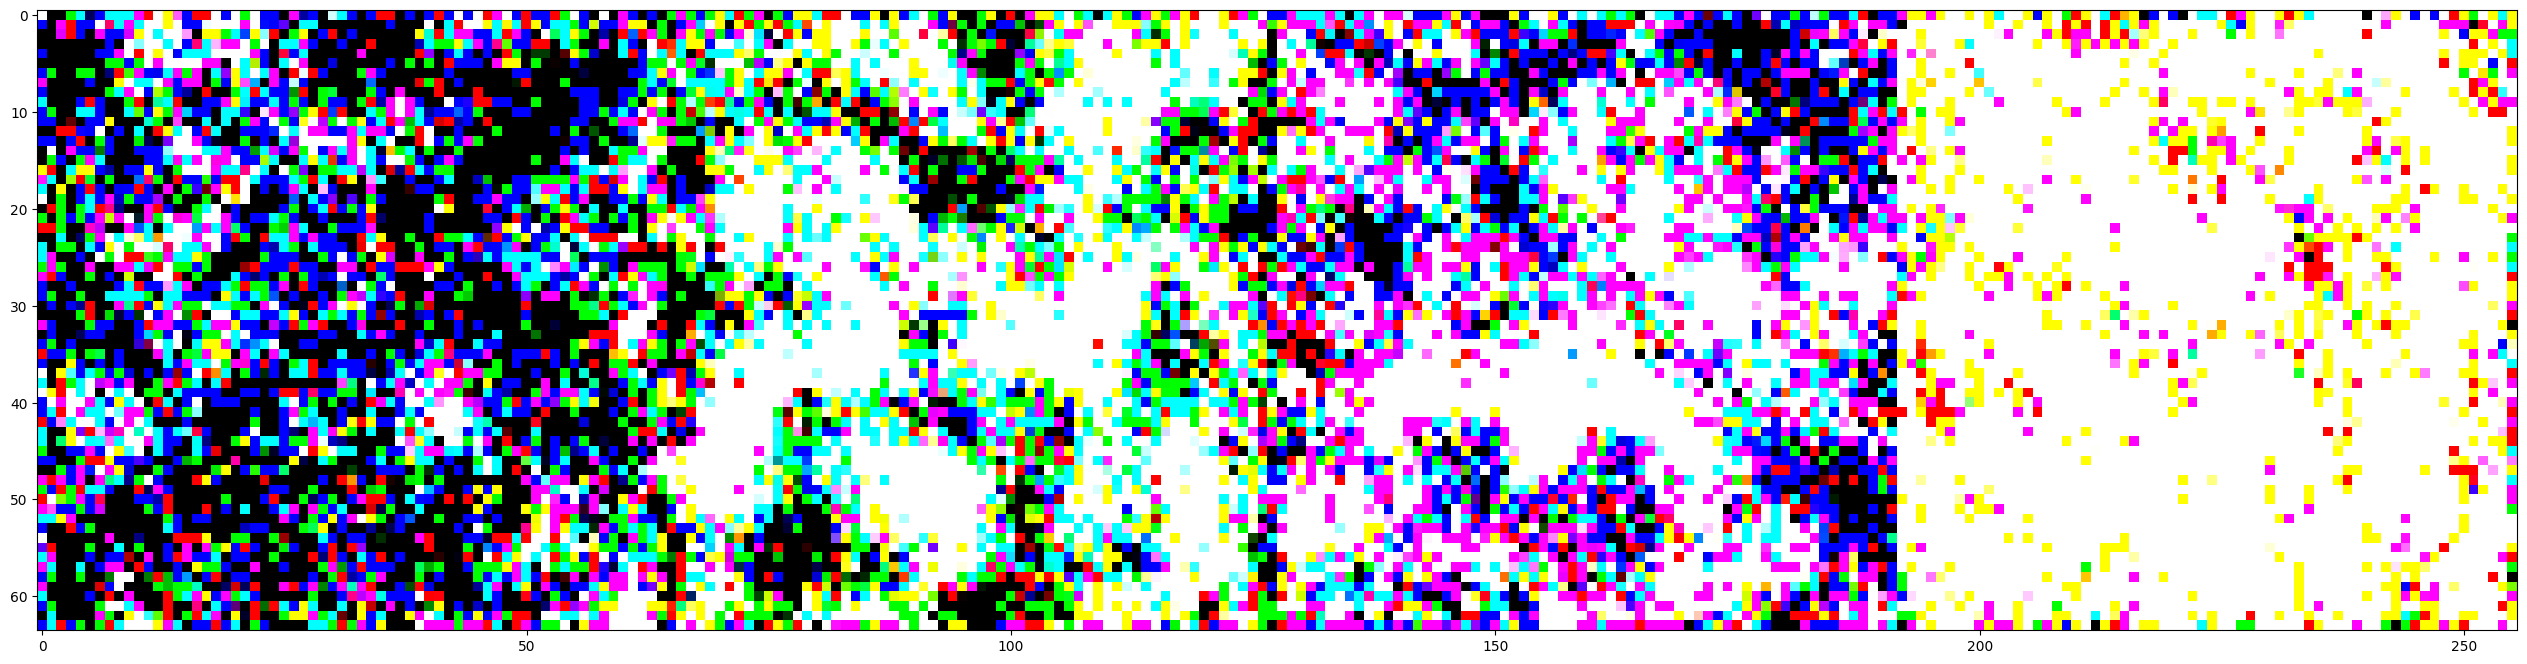

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


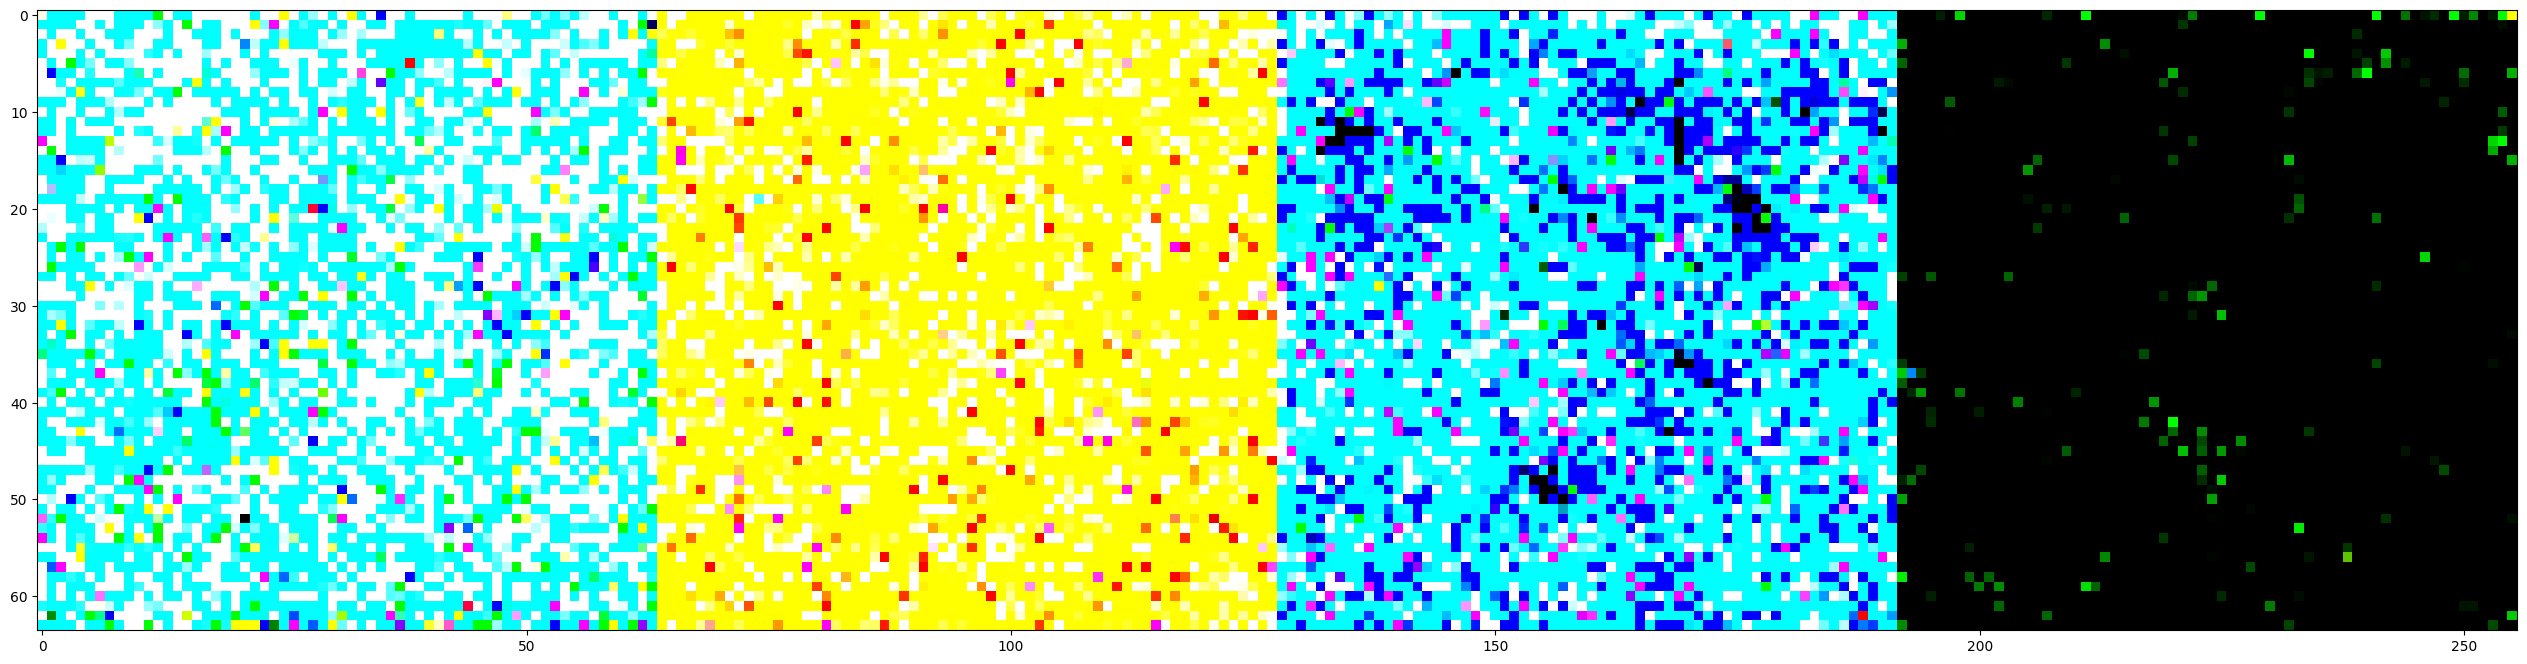

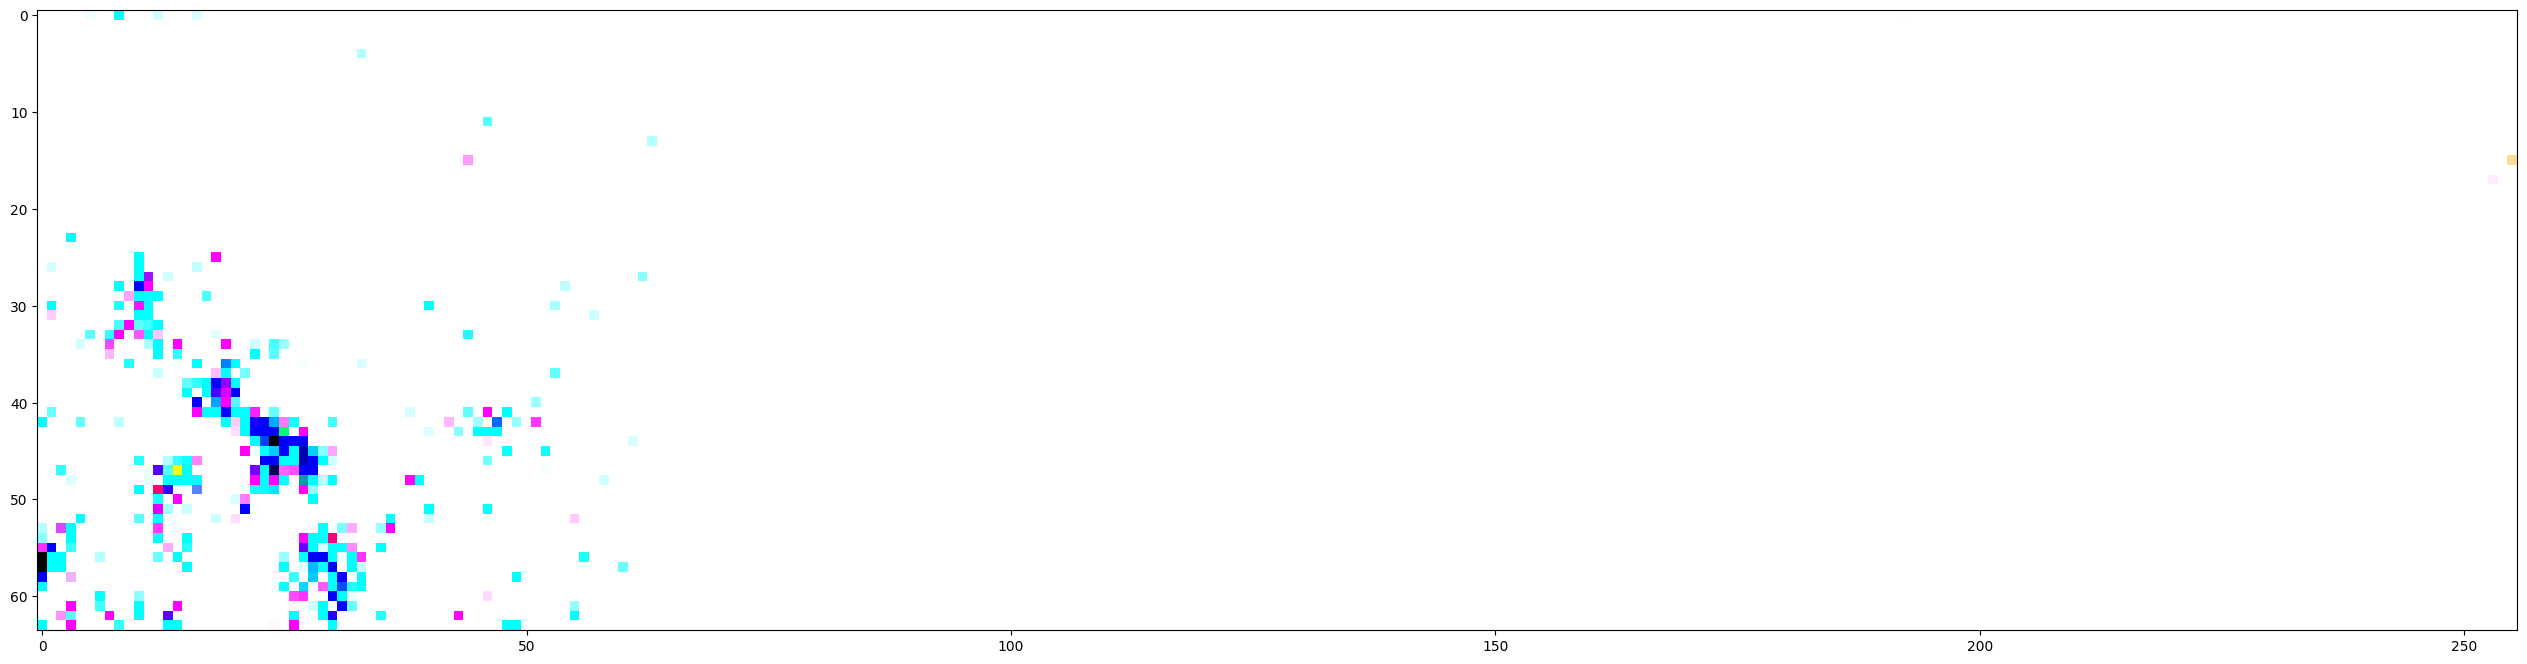

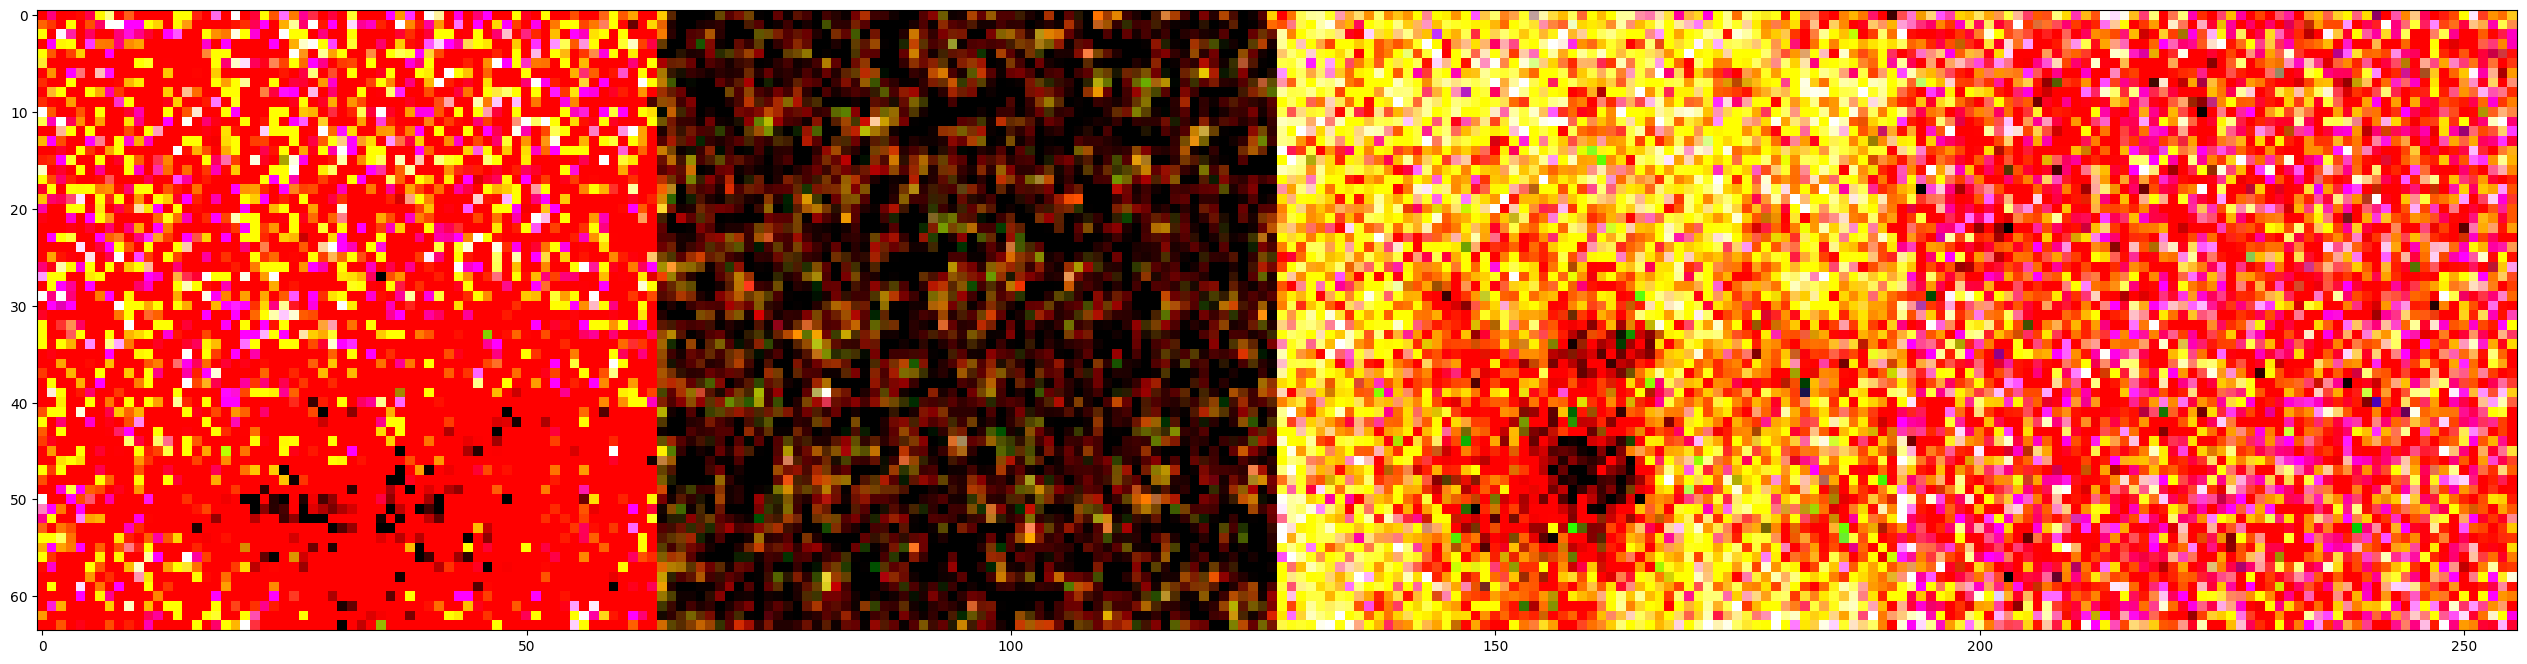

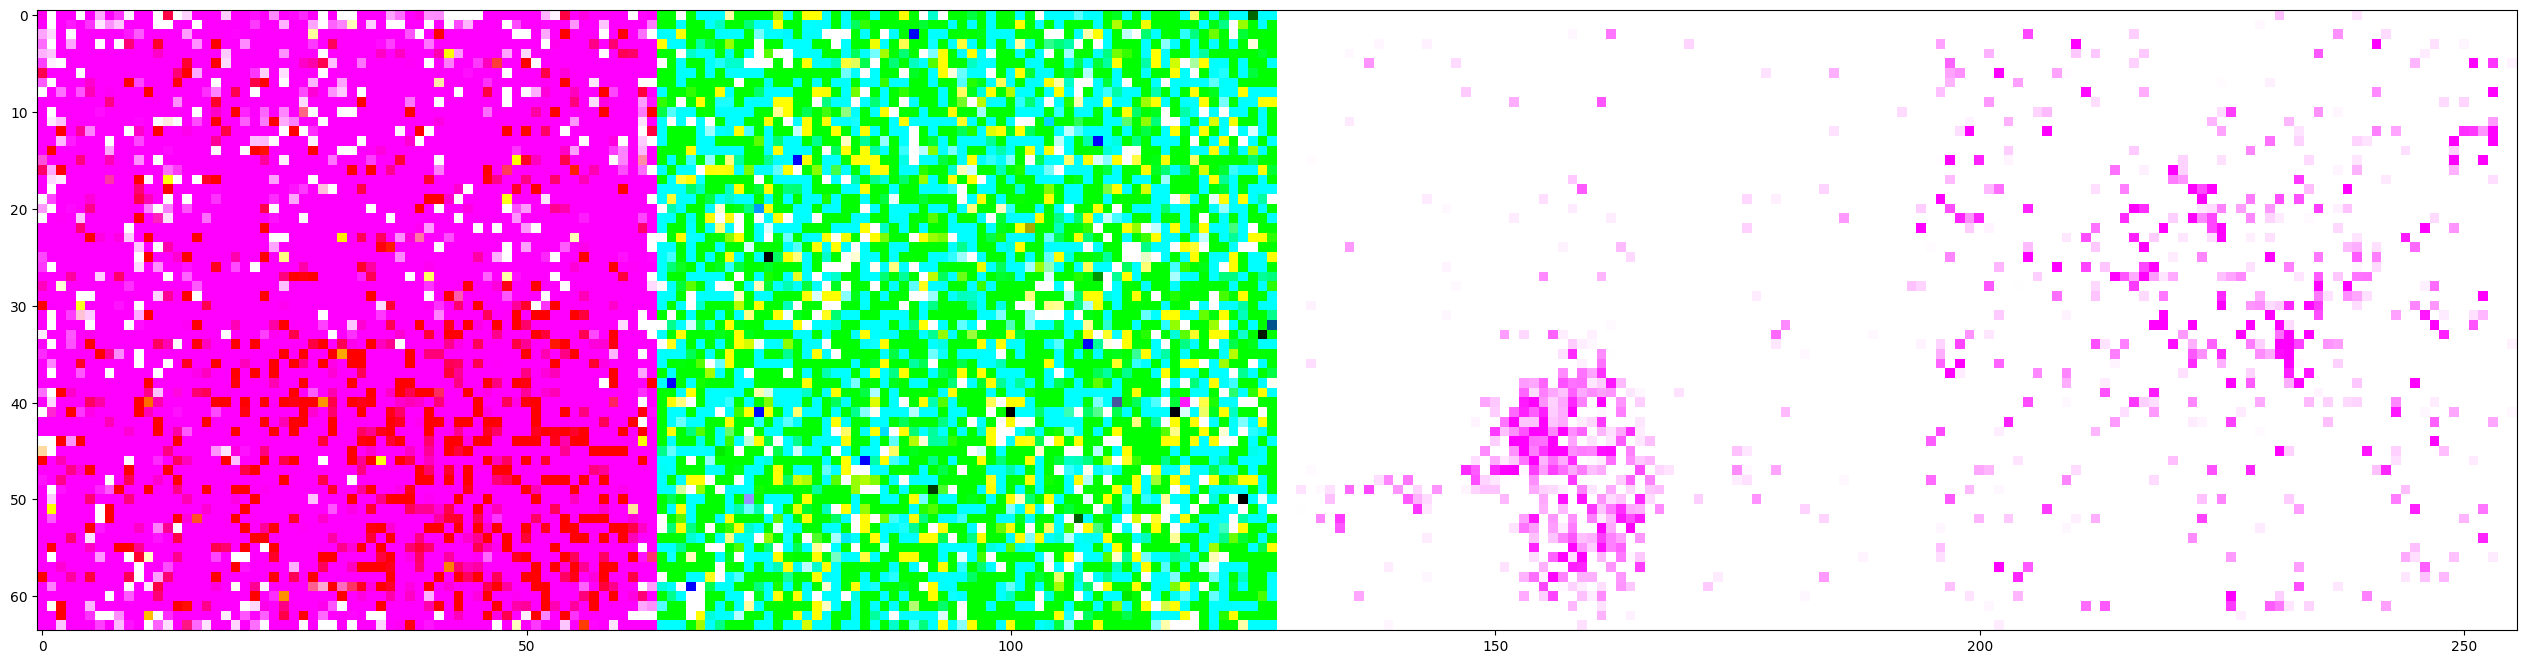

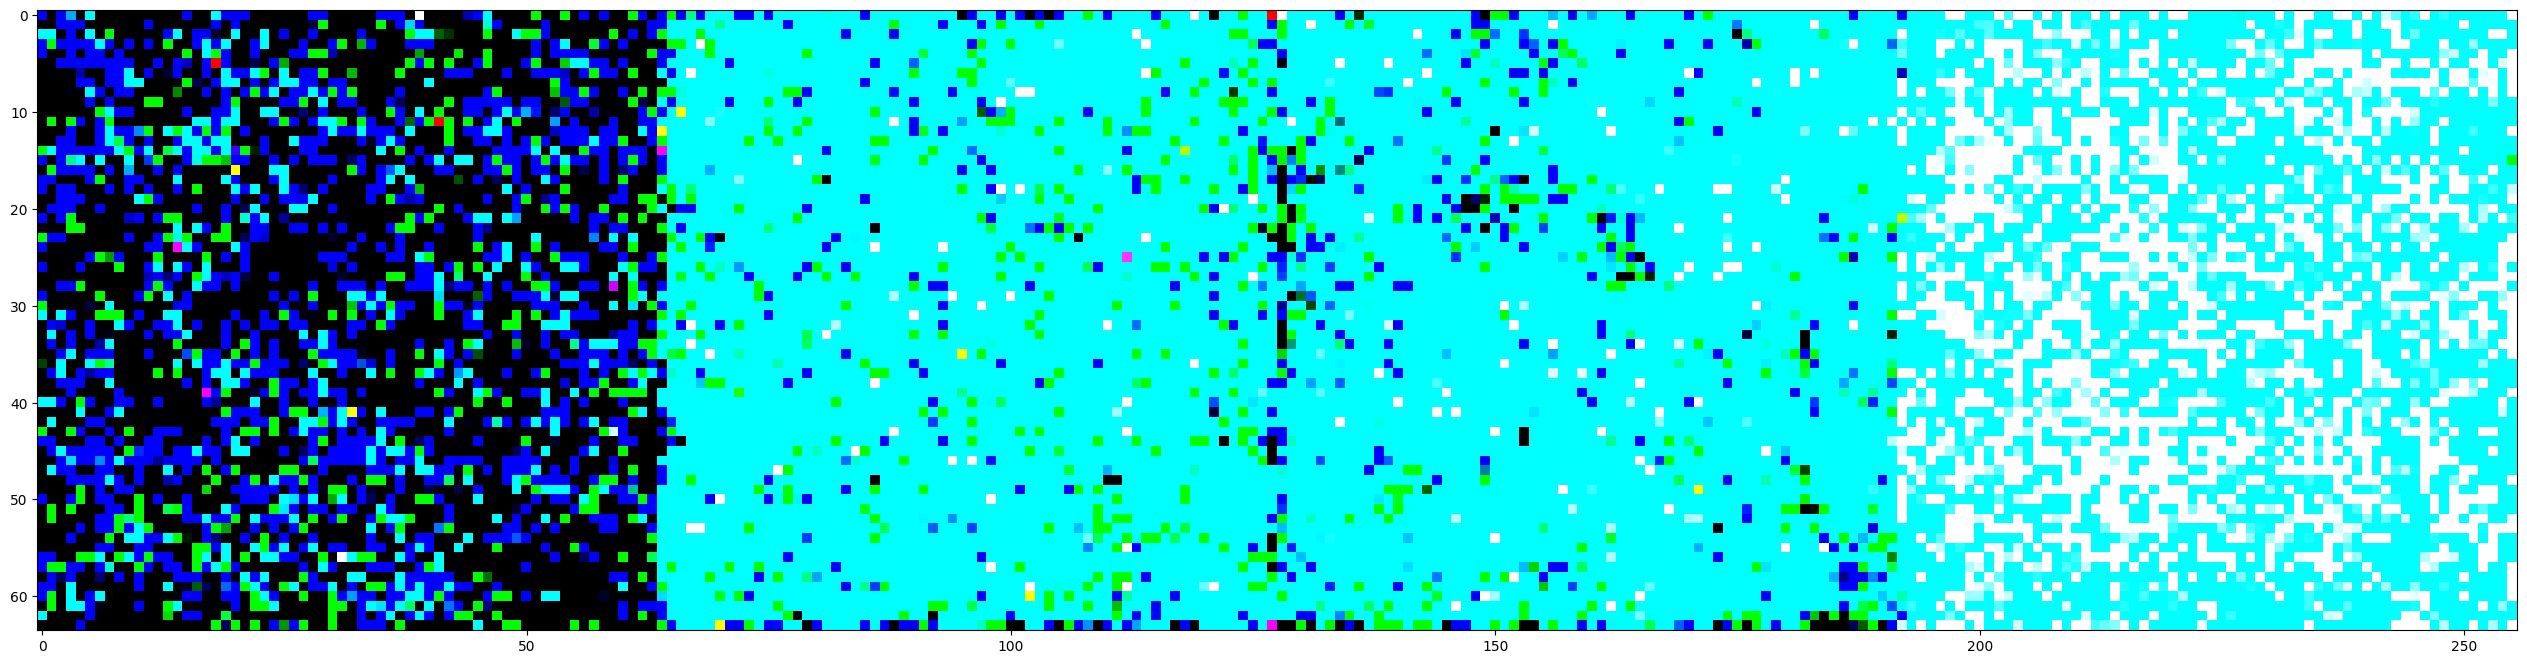

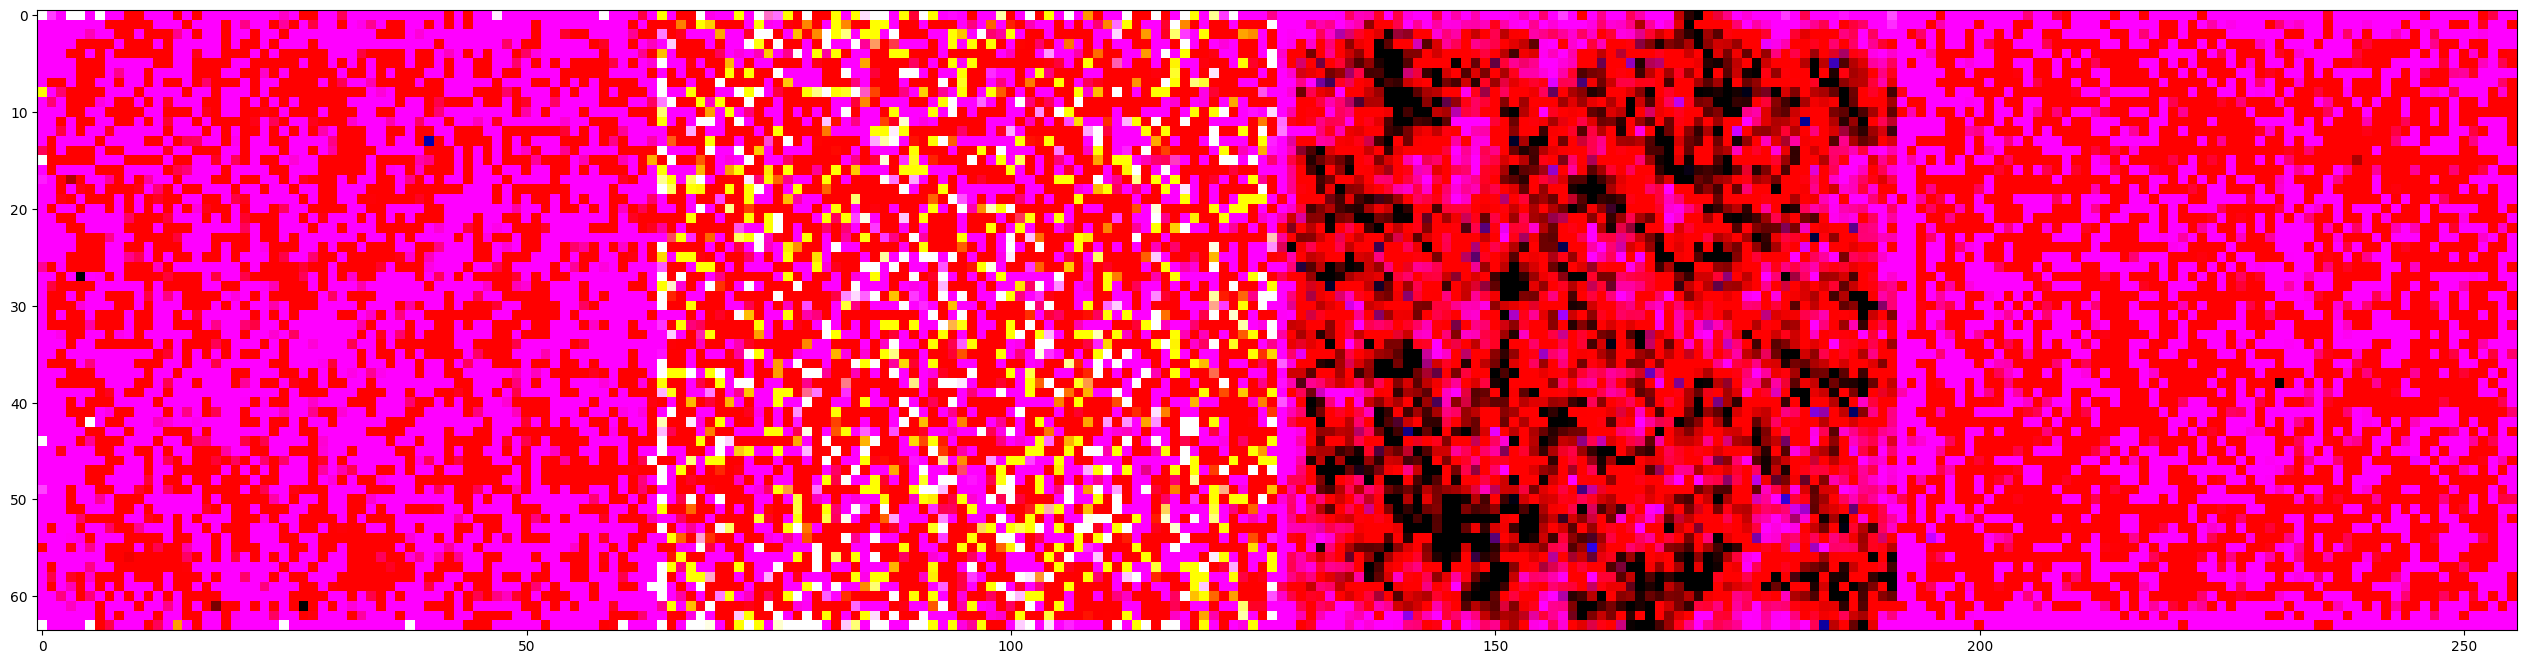

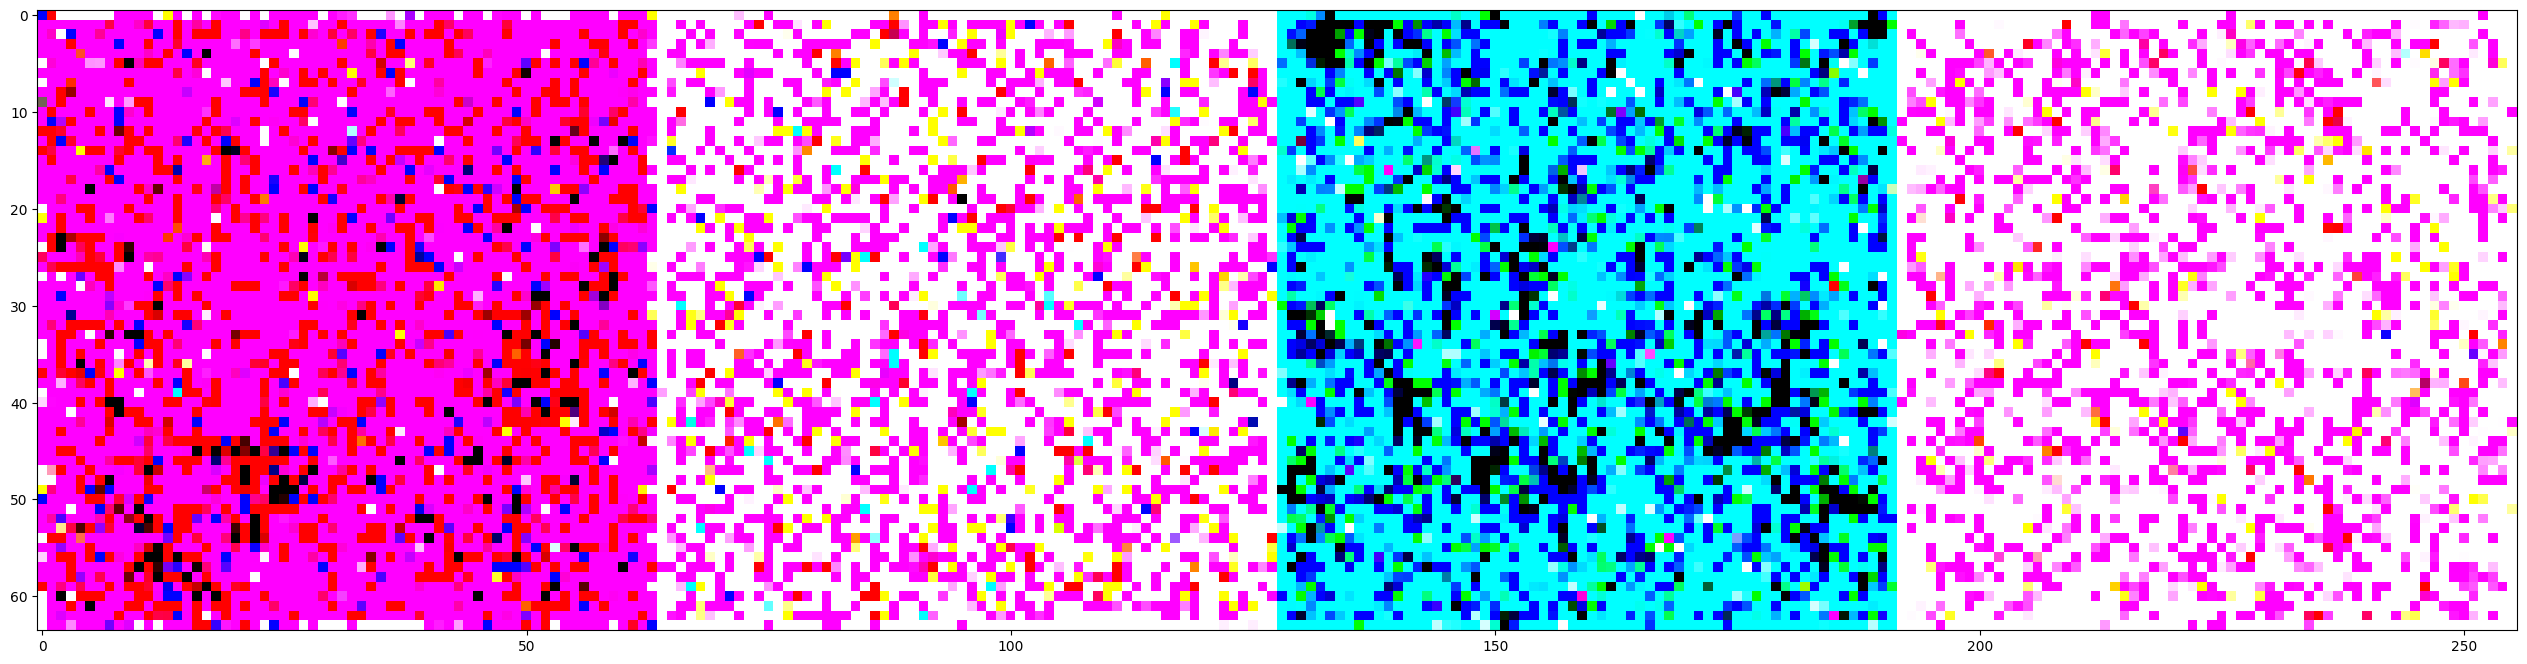

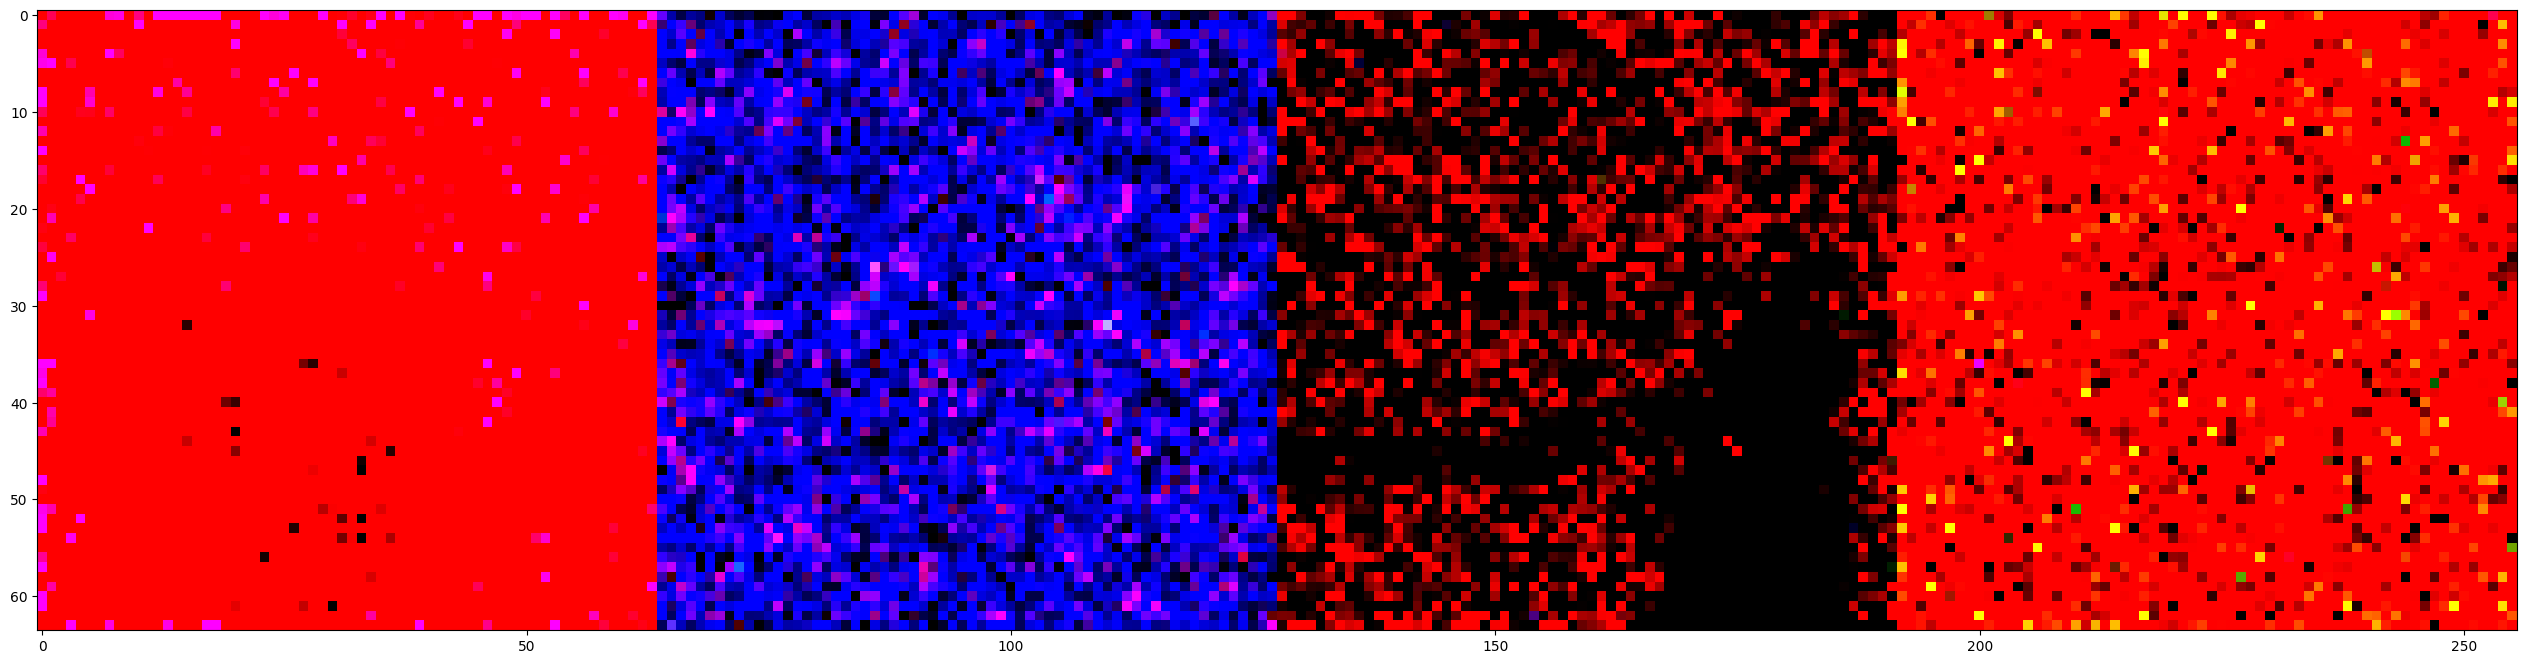

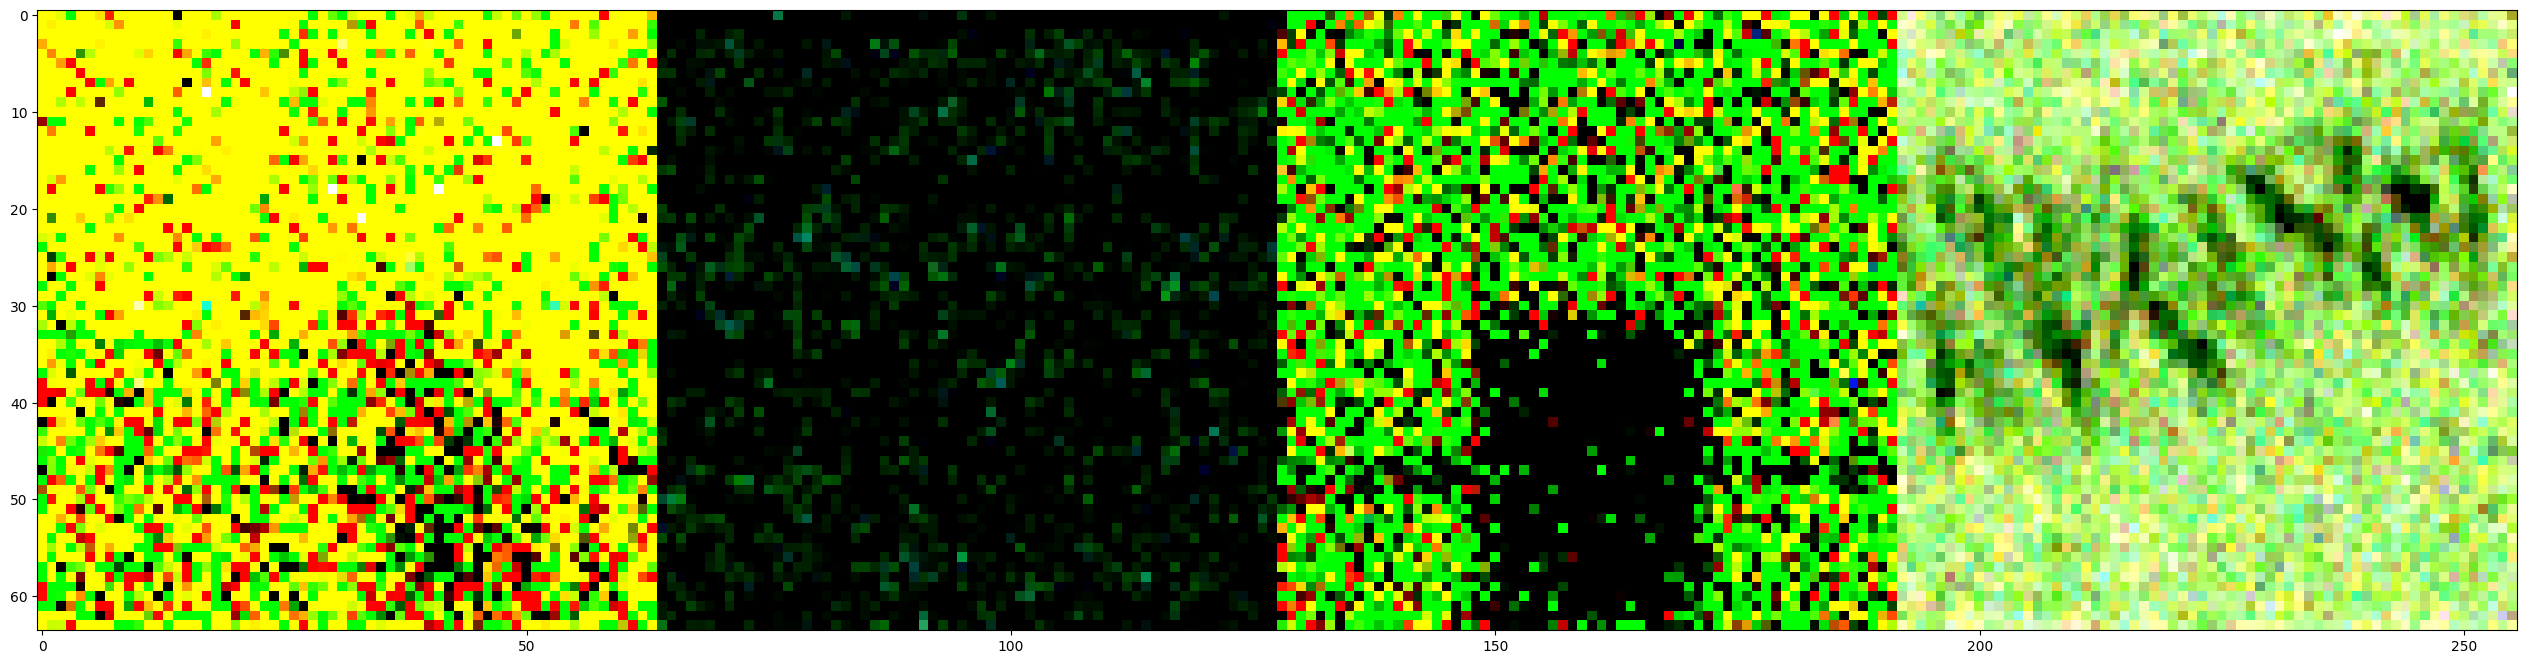

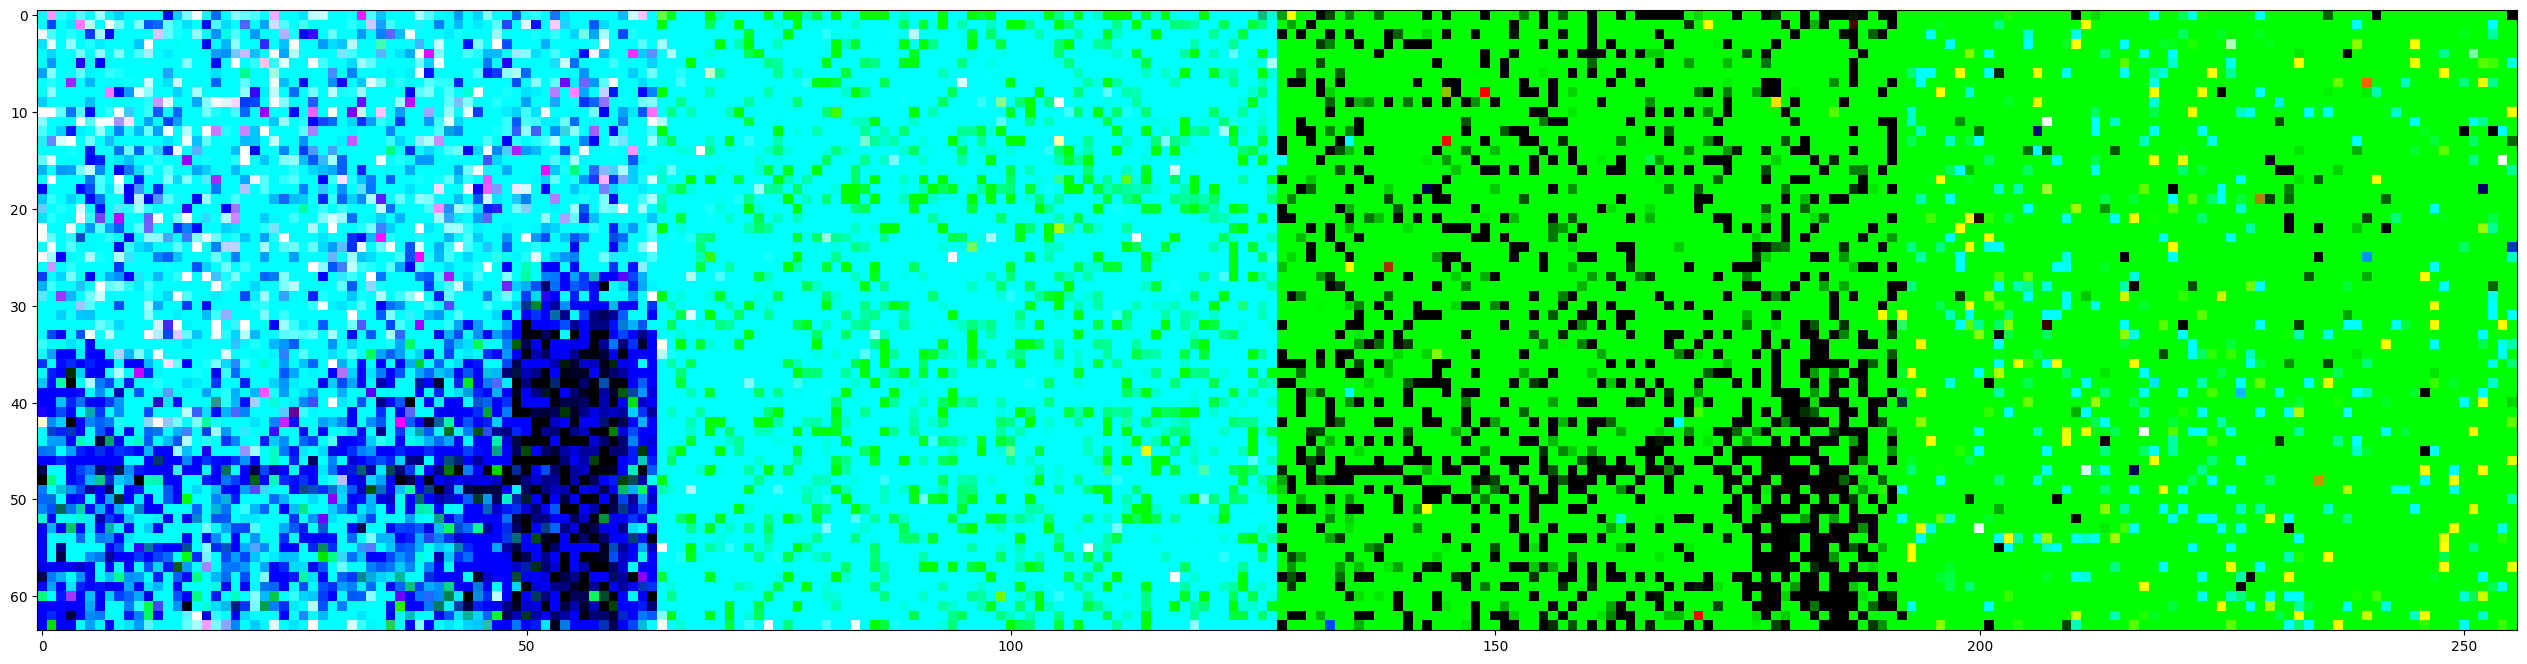

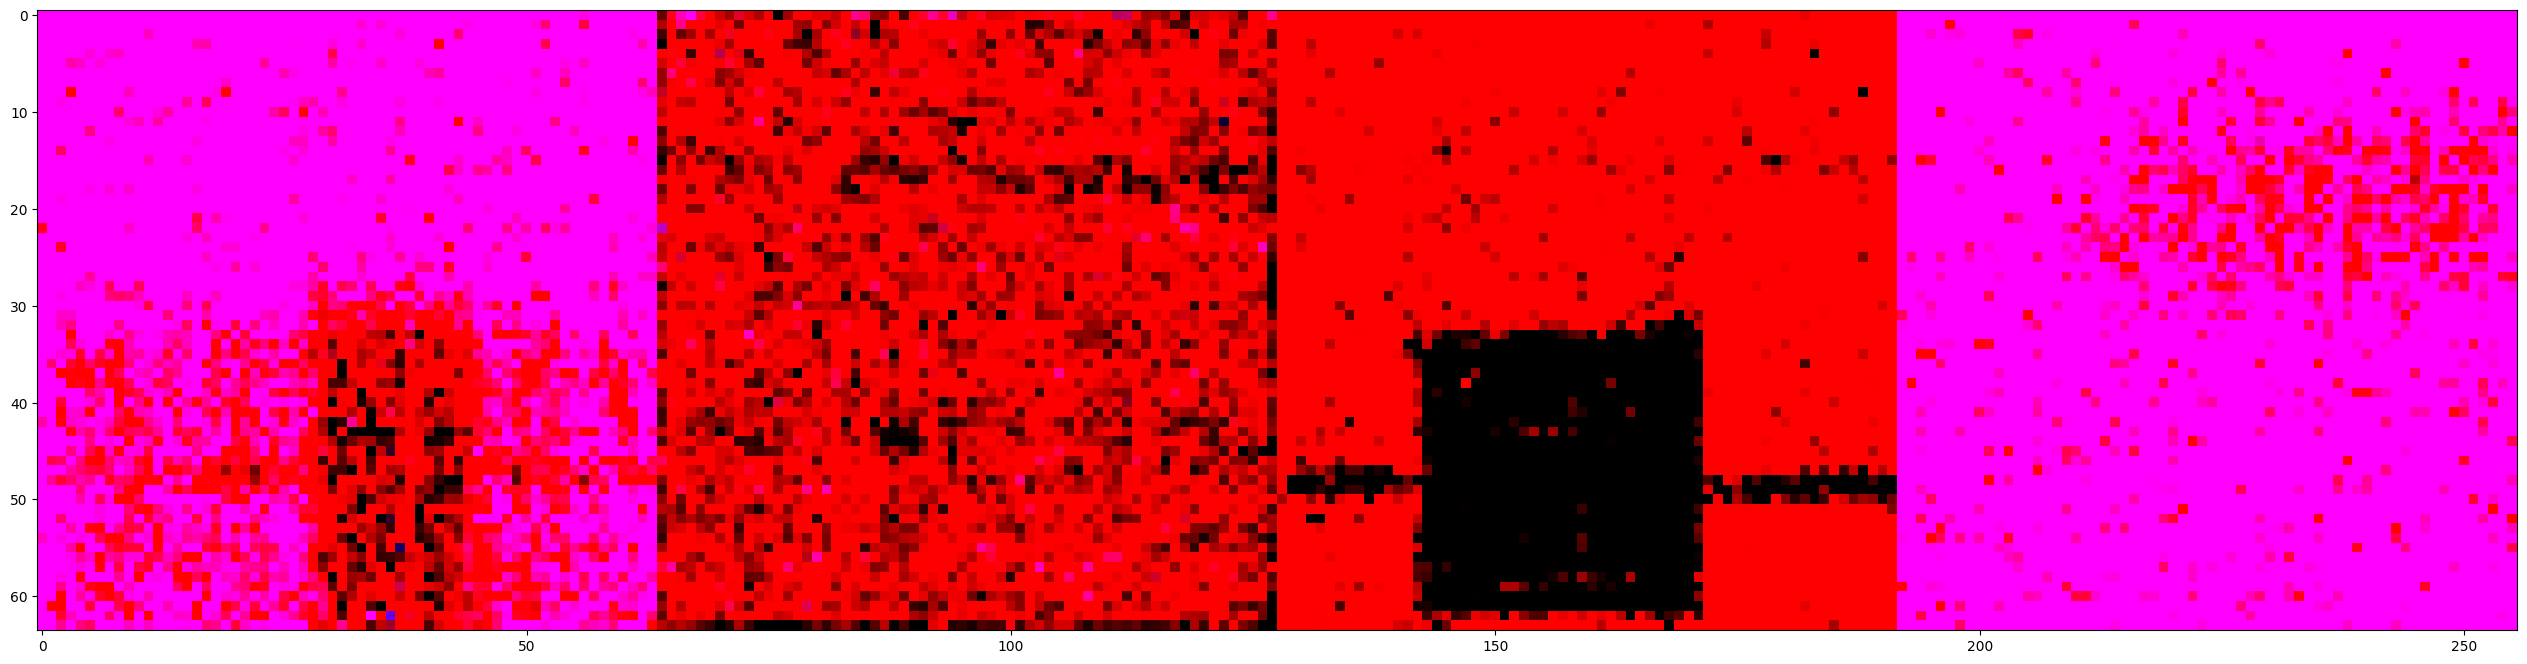

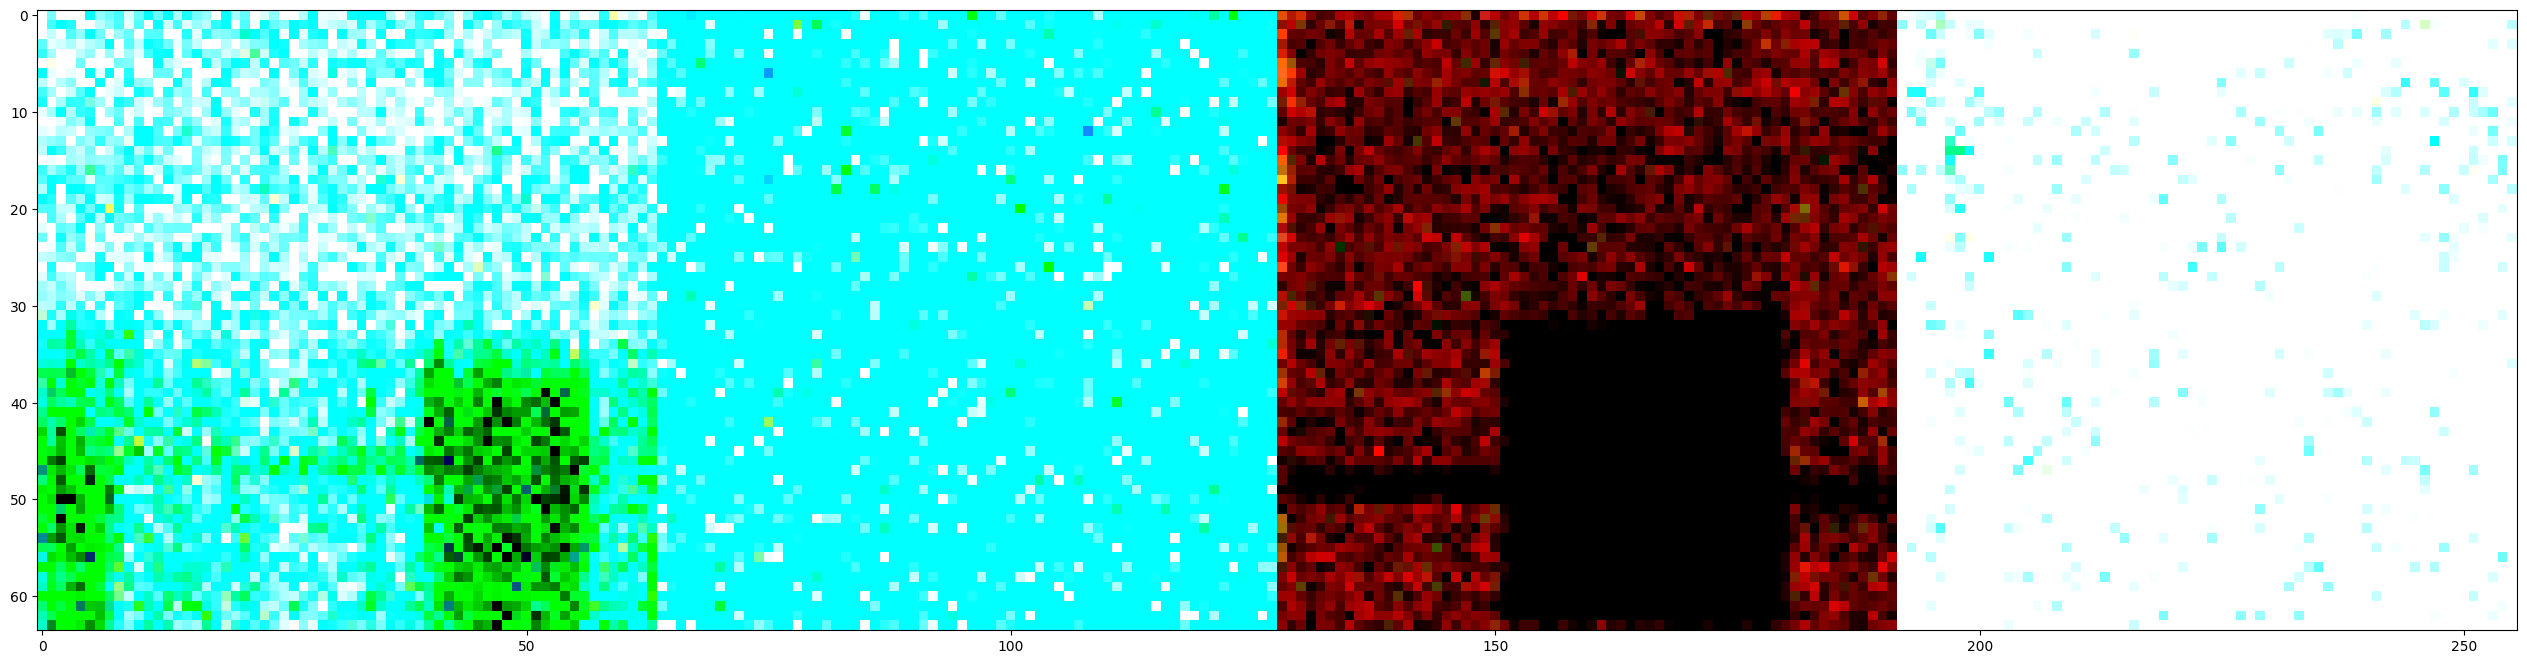

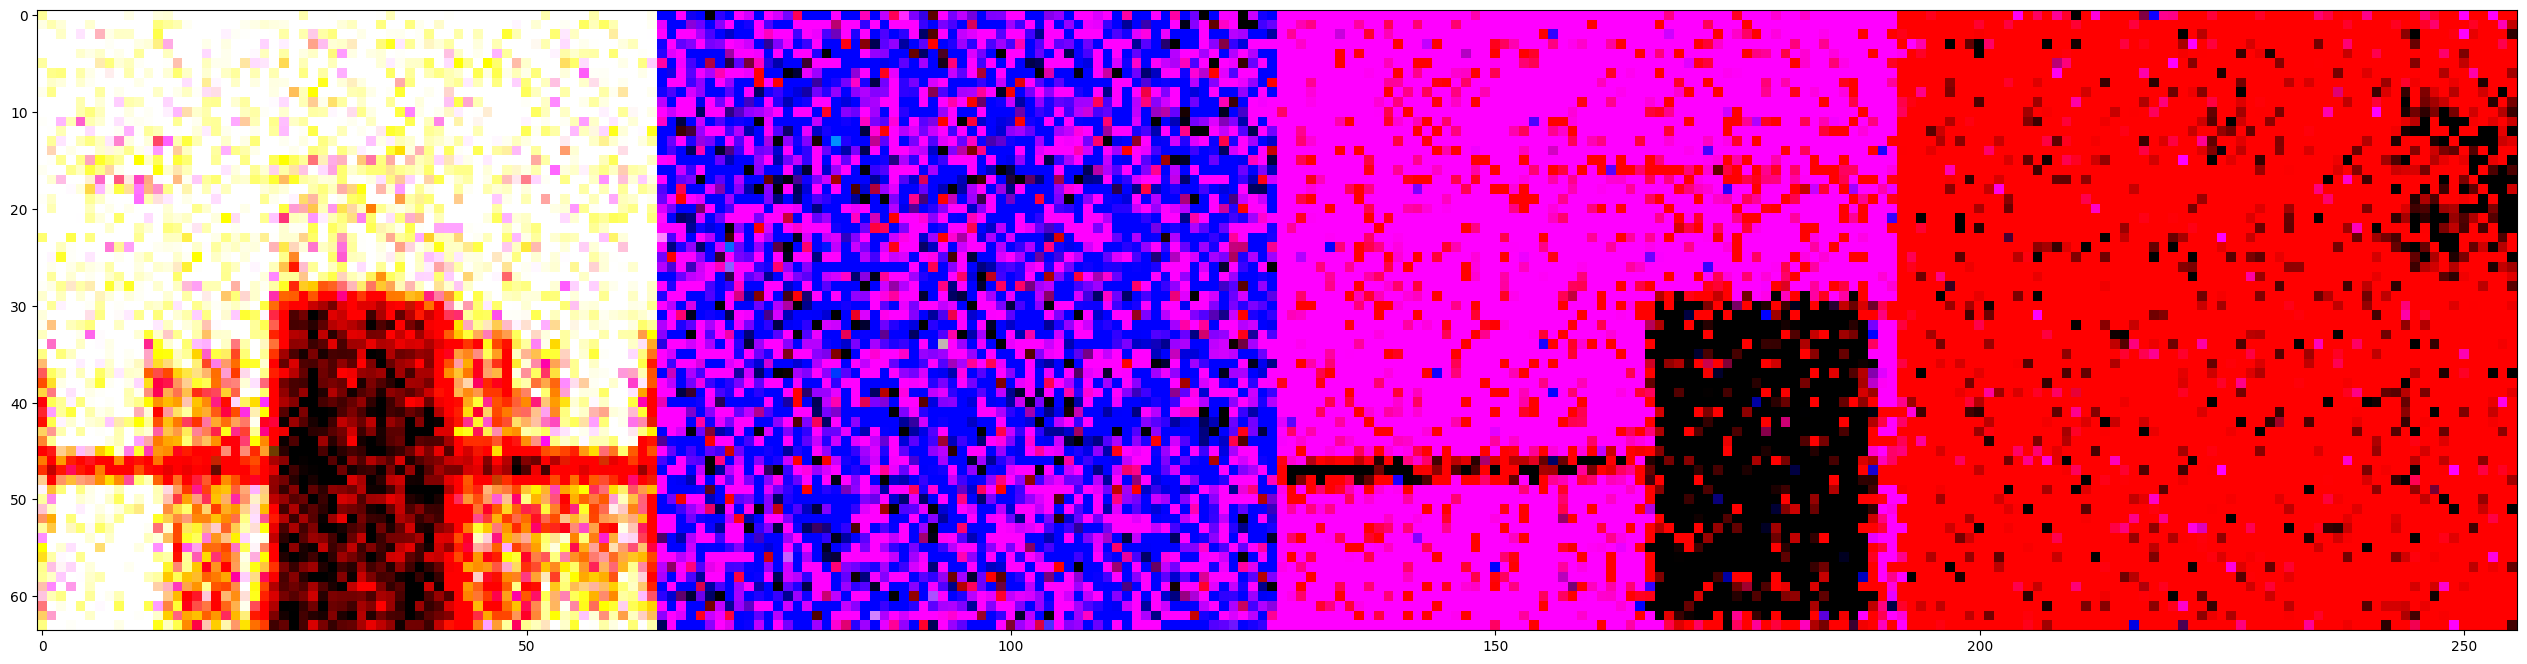

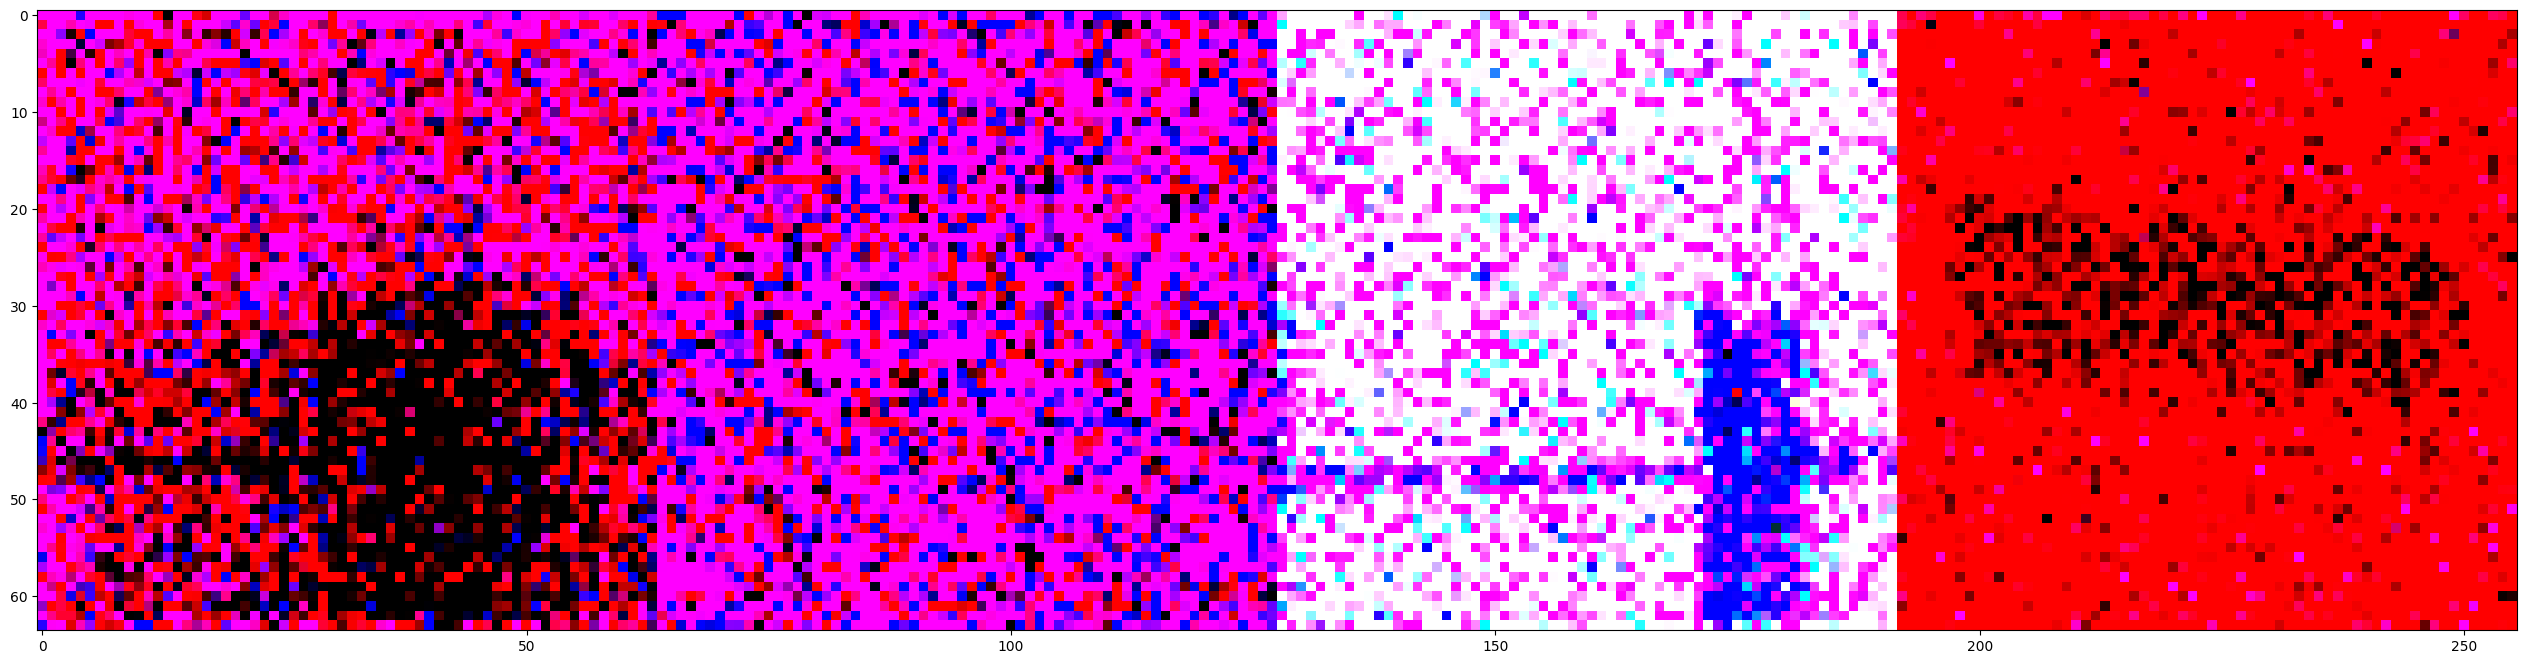

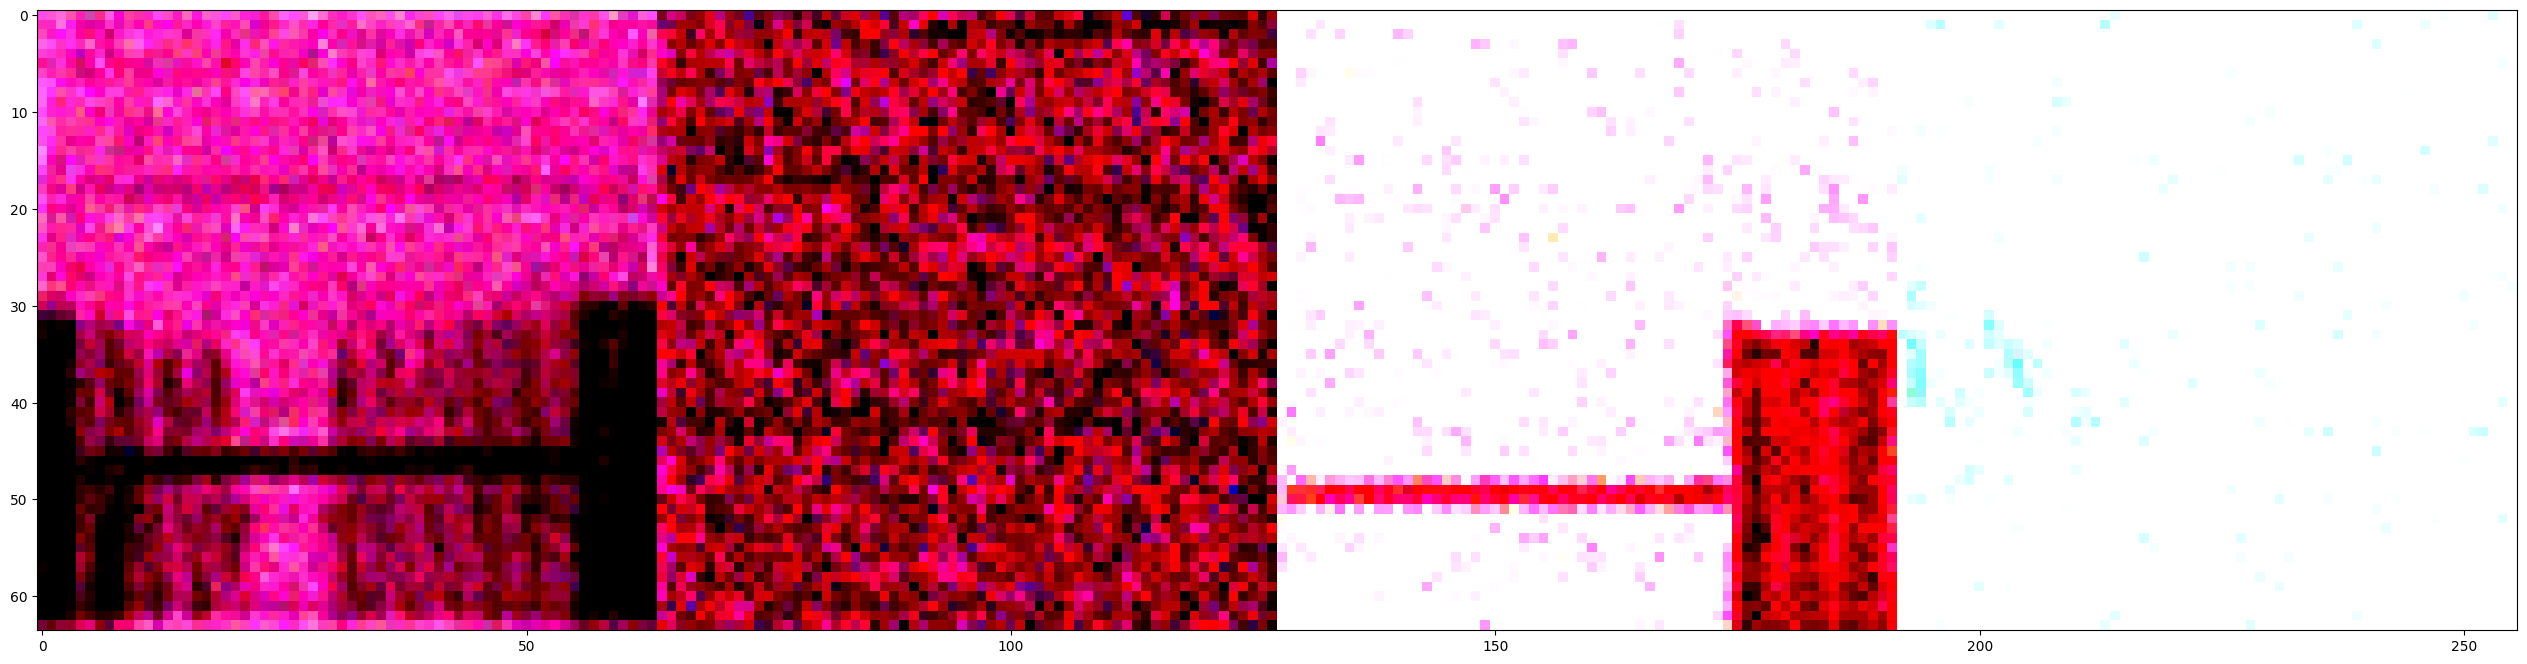

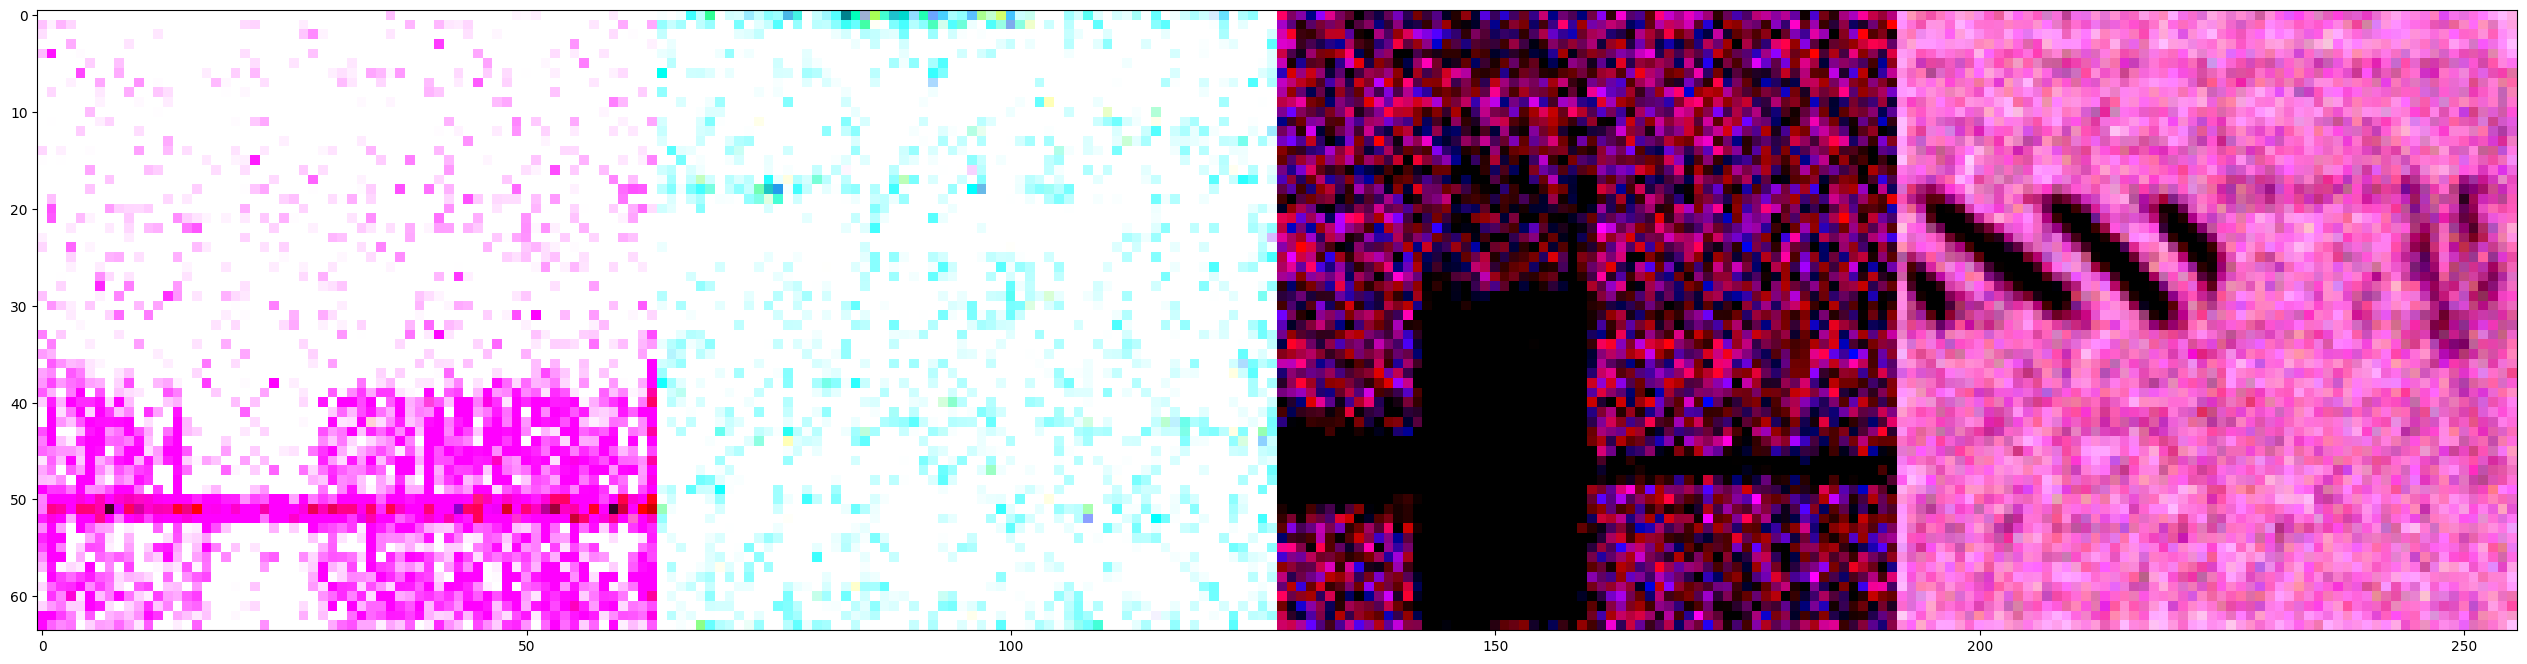

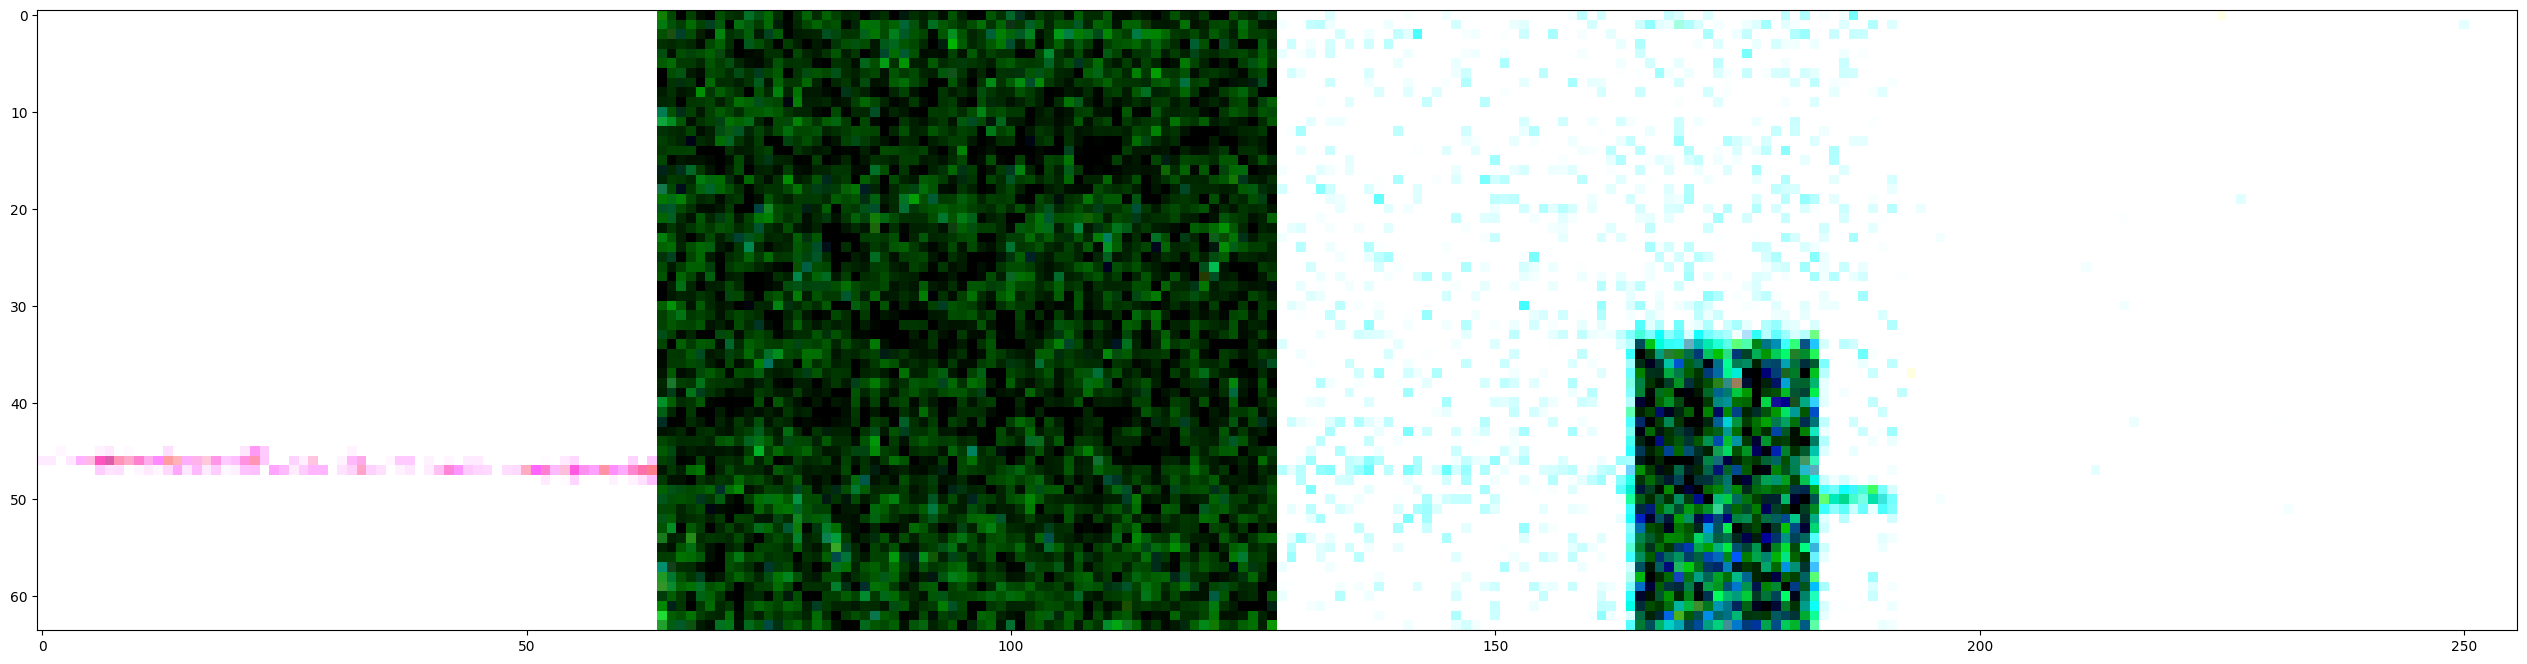

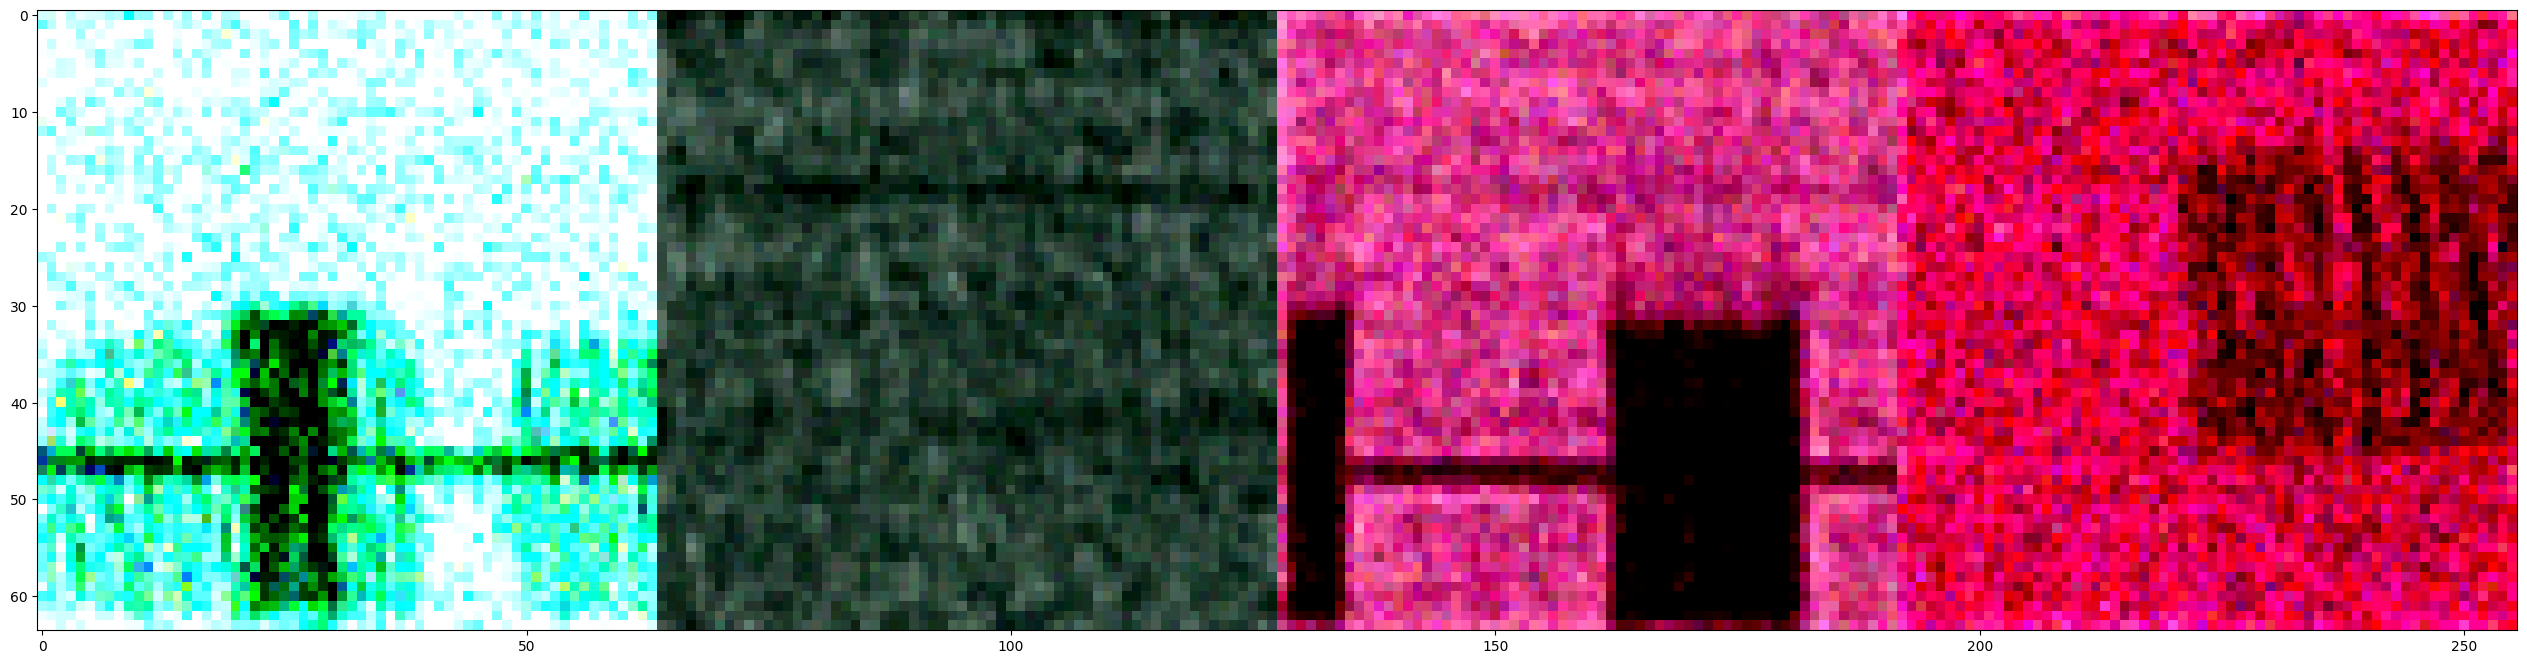

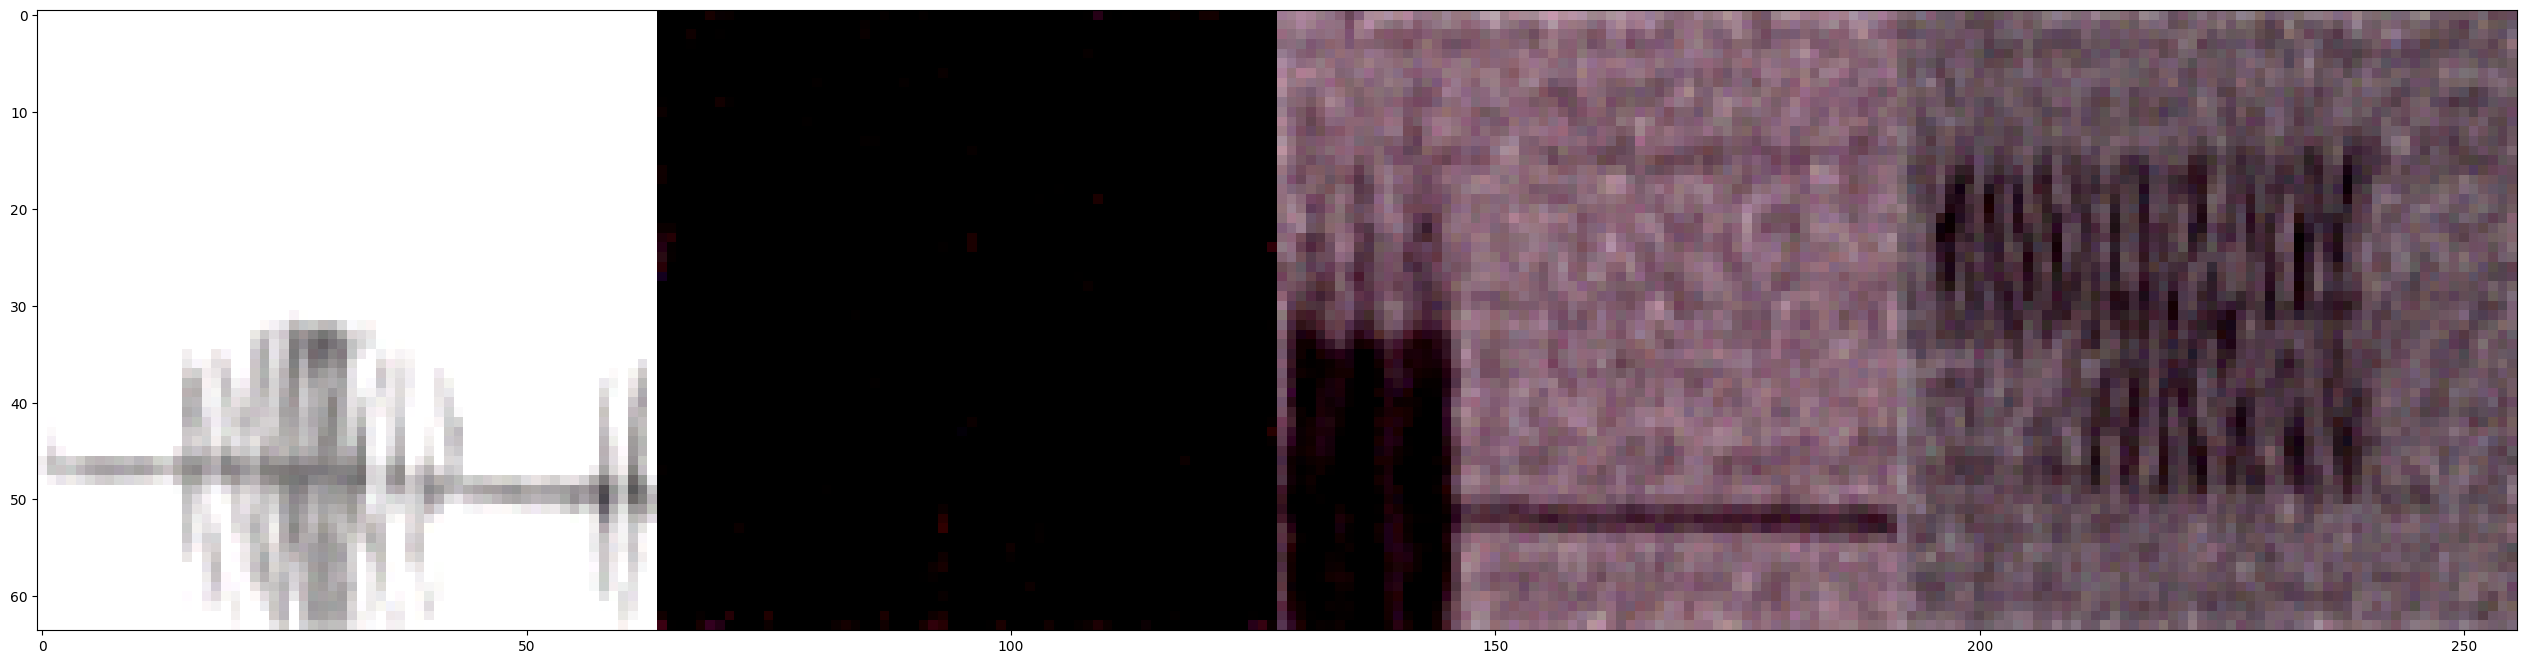

wandb: Adding directory to artifact (./models/DDPM_conditional)... Done. 0.8s


learning_rate,▁▁▂▂▃▄▅▆▇▇███████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁▁▁▁
train_mse,▂▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,▂▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
learning_rate,0.0
train_mse,0.05348
val_mse,1.94057


In [12]:
config = SimpleNamespace(
    run_name = "DDPM_conditional",
    epochs = 200,
    seed = 42,
    batch_size = 10,
    img_size = 64,
    num_classes = 4,
    dataset_path = "/content/drive/MyDrive/image_dataset",
    device = "cuda",
    lr = 5e-3,
    slice_size = 1,
    noise_steps=1000,
    train_folder = "train",
    val_folder = "test",
    do_validation = True,
    fp16 = True,
    log_every_epoch = 10,
    num_workers=10)


logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

def parse_args(config):
    parser = argparse.ArgumentParser(description='Process hyper-parameters')
    parser.add_argument('--run_name', type=str, required=False,default=config.run_name, help='name of the run')
    parser.add_argument('--epochs', type=int,required=False, default=config.epochs, help='number of epochs')
    parser.add_argument('--seed', type=int,required=False, default=config.seed, help='random seed')
    parser.add_argument('--batch_size', type=int, required=False,default=config.batch_size, help='batch size')
    parser.add_argument('--img_size', type=int, required=False, default=config.img_size, help='image size')
    parser.add_argument('--num_classes', type=int, required=False,default=config.num_classes, help='number of classes')
    parser.add_argument('--dataset_path', type=str,required=False, default=config.dataset_path, help='path to dataset')
    parser.add_argument('--device', type=str, required=False,default=config.device, help='device')
    parser.add_argument('--lr', type=float, required=False,default=config.lr, help='learning rate')
    parser.add_argument('--slice_size', type=int,required=False, default=config.slice_size, help='slice size')
    parser.add_argument('--noise_steps', type=int, required=False,default=config.noise_steps, help='noise steps')
    parser.add_argument("-f", required=False)
    #parser.add_argument('--train_folder', type=str, default=config.train_folder, help='train folder')
    #parser.add_argument('--val_folder', type=str, default=config.val_folder, help='test folder')
    #parser.add_argument('--fp16', type=bool, default=config.fp16, help='fp16')
    #parser.add_argument('--log_epoch', type=int, default=config.log_every_epoch, help='log_every_epoch')
    #parser.add_argument('--num_workers', type=int, default=config.num_workers, help='num_workers')
    args = vars(parser.parse_args())

    # update config with parsed args
    for k, v in args.items():
        setattr(config, k, v)


if __name__ == '__main__':
    parse_args(config)

    ## seed everything
    utils.set_seed(config.seed)

    diffuser = Diffusion(config.noise_steps, img_size=config.img_size, num_classes=config.num_classes)
    with wandb.init(project="train_sd", group="train", config=config):
        diffuser.prepare(config)
        diffuser.fit(config)


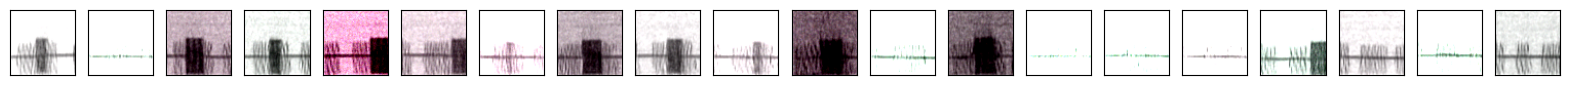

In [14]:
diffuser.model.load_state_dict(torch.load('./models/DDPM_conditional/ema_ckpt.pt'), strict = False)
label_sample = (torch.ones(20) * 0).long()
device = "cuda"
sample = diffuser.sample(False, label_sample.to(device))
plt.figure(figsize=(20, 20))

for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.imshow(sample[i].permute(1, 2, 0).detach().cpu().numpy())

    plt.gca().axes.xaxis.set_visible(False)
    plt.gca().axes.yaxis.set_visible(False)


In [34]:
import torch
from matplotlib import pyplot as plt

def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

n = 10
device = "cuda"
#model = UNet_conditional(num_classes=4).to(device)
#ckpt = torch.load("/content/models/DDPM_conditional/ema_ckpt.pt")
#model.load_state_dict(ckpt)
diffusion = Diffusion(img_size=64, device=device, num_classes=4)
diffusion.load('/content/models/DDPM_conditional/')
y = torch.ones((10) * 4).long()
x = diffusion.sample(use_ema=True, labels=y)
plot_images(x)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [18]:
import wandb, torch
from models import *
from fastcore.all import *

model_artifact="/content/models/DDPM_conditional/ema_ckpt.pt"

run = wandb.init()
artifact = run.use_artifact(model_artifact, type='model')
artifact_dir = artifact.download()
model_cpkt_path = Path(artifact_dir)

wandb: Currently logged in as: amandash. Use `wandb login --relogin` to force relogin


CommError: Invalid artifact path: /content/models/DDPM_conditional/ema_ckpt.pt